In [192]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig 
import multiprocessing as mp

In [193]:
FRAME_SIZE = 8192 
HOP_SIZE = 2048

In [194]:
plt.style.use( ['science', 'no-latex'])

# Functions

In [195]:
# def plot_magnitude_spectrum(signal, title, sr, f_ratio=1):
#     ft = np.fft.fft(signal)
#     magnitude_spectrum = np.abs(ft) 

#     #plot mag spectrum
#     plt.figure(figsize=(18,5))
    
#     frequency = np.linspace(0, sr, len(magnitude_spectrum))
#     no_freq_bins = int(len(frequency)*f_ratio)
    
#     plt.plot(frequency[:no_freq_bins], magnitude_spectrum[:no_freq_bins])
#     plt.title(title)
#     plt.xlabel("Frequency(Hz)")
    
#     plt.show()
    
def plot_spectrogram(Y, sr, hop_length, y_axis='linear', title='title'):
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(Y,
                            sr=sr,
                            hop_length=hop_length,
                            x_axis='time',
                            y_axis=y_axis)
    
    #plt.rcParams.update({'font.size': 20})
    plt.title(title)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(format="%+2.f dB")
    
def plot_frame(SpectrogramEnergy, frame_no, fLower = 50, fUpper= 1000):
    magnitude_spectrum = np.abs(SpectrogramEnergy.T[frame_no]) 

    ##plot mag spectrum
    plt.figure(figsize=(18,5))
    
    frequency = np.linspace(0, sr/2, len(magnitude_spectrum))
    no_freq_bins = int(len(frequency)*0.25)
    
    plt.plot(frequency[:no_freq_bins], magnitude_spectrum[:no_freq_bins])
    plt.title("Single Frame of STFT")
    plt.xlabel("Frequency(Hz)")
    #plt.semilogx()
    plt.xlim(fLower,fUpper)
    plt.show()
    
def plot_frame_peaks(SpectrogramEnergy, frame_no, fLower = 50, fUpper= 1000):
    magnitude_spectrum = np.abs(SpectrogramEnergy.T[frame_no]) 
    
    #peak find
    peaks, _ = sig.find_peaks(magnitude_spectrum, prominence=1)
    peaks = peaks[:int(len(peaks)/2)]
    
    ##plot mag spectrum
    plt.figure(figsize=(18,5))
    
    frequency = np.linspace(0, sr/2, len(magnitude_spectrum))
    no_freq_bins = int(len(frequency)*0.25)
    
    plt.plot(frequency[:no_freq_bins], magnitude_spectrum[:no_freq_bins])
    
    plt.plot(frequency[peaks], magnitude_spectrum[peaks], "x")
    
    plt.title("Single Frame of STFT")
    plt.xlabel("Frequency(Hz)")
    #plt.semilogx()
    plt.xlim(fLower,fUpper)
    plt.show()

In [196]:
def get_harmonics(peaks, fundamental):
    harmonics = []
    harmonics_even = []
    harmonics_odd = []
    freqs = librosa.core.fft_frequencies(sr, n_fft=FRAME_SIZE)
    for h in range(2, 12):
        for i in range(len(peaks)):
            freq_ratio = (freqs[peaks[i]]/(h * fundamental))
            if np.abs(freq_ratio-1) < 0.05:
                harmonics.append(peaks[i])
                break
            
    for j in range(len(harmonics)):
        if round(freqs[harmonics[j]]/(fundamental))%2 == 0:
            harmonics_even.append(harmonics[j])
        else: 
            harmonics_odd.append(harmonics[j])
    
    return [harmonics, harmonics_even, harmonics_odd]

In [253]:
def get_harmonics2(peaks, fundamental):
    harmonics = []
    harmonics_even = []
    harmonics_odd = []
    f_fund = []
    freqs = librosa.core.fft_frequencies(sr, n_fft=FRAME_SIZE)
    
    for f in range(len(peaks)):
        if np.abs(freqs[peaks[f]]/(fundamental) - 1) < 0.1:
            f_fund.append(peaks[f])  
    
    for h in range(2, 12):
        for i in range(len(peaks)):
            freq_ratio = (freqs[peaks[i]]/(h * fundamental))
            if np.abs(freq_ratio-1) < 0.05:
                harmonics.append(peaks[i])
                break
            
    for j in range(len(harmonics)):
        if round(freqs[harmonics[j]]/(fundamental))%2 == 0:
            harmonics_even.append(harmonics[j])
        else: 
            harmonics_odd.append(harmonics[j])

    return [harmonics, harmonics_even, harmonics_odd, f_fund]

In [230]:
def odd_even_energy(harmonics_odd, harmonics_even, SpectrogramEnergy):
    #Sum odd Energies
    magnitude_spectrum = np.abs(SpectrogramEnergy) 
    Odd_energy = 0
    Even_energy = 0
    for o in range(len(harmonics_odd)):
        Odd_energy += np.abs(magnitude_spectrum[harmonics_odd[o]]) ** 2

    for e in range(len(harmonics_even)):
        Even_energy += np.abs(magnitude_spectrum[harmonics_even[e]]) ** 2
    
    return [Odd_energy, Even_energy]

In [231]:
def Salience_peaks_plot(Signal, frame, sr=48000, frame_size=FRAME_SIZE, hop_length=HOP_SIZE):
    S = np.abs(librosa.stft(Signal, n_fft=frame_size, hop_length=hop_length))
    freqs = librosa.core.fft_frequencies(sr, n_fft=frame_size)
    harms = [1, 2, 3, 4]
    weights = [1, 1, 1, 1]
    S_sal = librosa.salience(S, freqs, harms, weights, fill_value=0)

    
    
    #peaks of salience for desired frame
    magnitude_spectrum = np.abs(S_sal.T[frame]) 
    
    #peak find
    peaks, _ = sig.find_peaks(magnitude_spectrum, prominence=0.01)
    #peaks = peaks[:int(len(peaks)/2)]

    frequency = np.linspace(0, sr/2, len(magnitude_spectrum))
    no_freq_bins = int(len(frequency)*0.25)

    plt.figure( figsize=(18,10))
    #plot Salience spectrogram
    plt.subplot(2,1,1)
    librosa.display.specshow(librosa.amplitude_to_db(S_sal, ref=np.max), sr=sr, hop_length=1024, y_axis='log', x_axis='time')
    plt.vlines(librosa.frames_to_time(frame),colors="r", ymax=20000, ymin=0)
    plt.colorbar()
    plt.title('Salience spectrogram')
    
    #plot peaks of salience at specific frame
    plt.subplot(2,1,2)
    plt.plot(frequency[:no_freq_bins], magnitude_spectrum[:no_freq_bins])
    plt.plot(frequency[peaks], magnitude_spectrum[peaks], "x")
    plt.title("Single Frame of Salience")
    plt.xlabel("Frequency(Hz)")
    plt.xscale("log")
    plt.xticks(ticks=[100, 200, 300, 1000, 2000])
    #plt.semilogy()
    plt.xlim(1,5000)
    plt.show()

In [232]:
def Salience_peaks(Signal, frame, sr=48000, frame_size=FRAME_SIZE, hop_length=HOP_SIZE):
    S = np.abs(librosa.stft(Signal, n_fft=frame_size, hop_length=hop_length))
    freqs = librosa.core.fft_frequencies(sr, n_fft=frame_size)
    harms = [1, 2, 3, 4, 5]
    weights = [1, 1, 1, 1, 1]
    S_sal = librosa.salience(S, freqs, harms, weights, fill_value=0)

    
    
    #peaks of salience for desired frame
    magnitude_spectrum = np.abs(S_sal.T[frame]) 
    
    #peak find
    peaks, _ = sig.find_peaks(magnitude_spectrum, prominence=0.01)
    #peaks = peaks[:int(len(peaks)/2)]

    return peaks

In [233]:
def OddtoEvenEnergyRatio(Signal, fundamental, sr=48000, framesize=FRAME_SIZE, hoplength=HOP_SIZE): #OLD FUNCITON
    
    STFT = np.abs(librosa.stft(Signal, n_fft=framesize, hop_length=hoplength))
    #Energy_spec = np.abs(STFT) ** 2
    OddEvenEnergyRatio = []
    for i in range(len(STFT.T)):
        currentframe_FT_spectrum = np.abs(STFT.T[i]) 
        
        peaks_currentframe = Salience_peaks(Signal, i, sr, framesize, hoplength)
        _, Even_peaks, Odd_peaks = get_harmonics(peaks_currentframe, fundamental)
        
        Even_energy, Odd_energy = odd_even_energy(Odd_peaks, Even_peaks, STFT.T[i])
        
        if Even_energy == 0:
            Energy_ratio_currentframe = 0
        else:
            Energy_ratio_currentframe = Odd_energy/Even_energy
        
        OddEvenEnergyRatio.append(Energy_ratio_currentframe)
    
    return OddEvenEnergyRatio

In [234]:
def OddEvenRatio(Signal, fundamental):
    OERlist = []
    Y_STFT = np.abs(librosa.stft(Signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)) ** 2
    for i in range(len(Y_STFT.T)):
        peaks=Salience_peaks(Signal, i)

        _, even_harms, odd_harms = get_harmonics(peaks, fundamental)
        Energy_spectrum_frame = np.abs(Y_STFT.T[i]) 
        harmonics = zip( odd_harms, even_harms)

        Total_Odd_Energy = 0
        Total_Even_Energy = 0
        for o, e in harmonics:
            Total_Odd_Energy += Energy_spectrum_frame[o]
            Total_Even_Energy += Energy_spectrum_frame[e]

        if Total_Even_Energy == 0:
            CurrentEnergyRatio = 0
        else:
            CurrentEnergyRatio = Total_Odd_Energy/Total_Even_Energy

        OERlist.append(CurrentEnergyRatio)
    return OERlist 

In [235]:
def plot_OER(OERSig1, OERSig2, OERSig3):
    STFT = librosa.stft(Dry_E2_String_Hi, n_fft=FRAME_SIZE)
    frames= range(len(STFT.T))
    t= librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 27})

    plt.plot(t, OERSig1, color="red", linewidth=1, label="Dry" )

    plt.plot(t, OERSig2, color="b",linewidth=1, label="Vox" )

    plt.plot(t, OERSig3,linewidth=1, label="JFET" )

    # plt.plot(t, OER_VT40Marsh,linewidth=1, label="VT40 UK Rock" )

    # plt.plot(t, OER_Cali,linewidth=1, label="VT40 US2x12" )

    # plt.plot(t, OER_VT40Mesa, color="darkred", linewidth=1, label="VT40 US Metal" )

    #plt.title("Odd to Even Harmonic Energy ratio")
    plt.ylabel("Odd to Even Energy Ratio")
    plt.xlabel('Time (s)')
    plt.grid(True, which="both", linestyle='--')

    plt.ylim(0,7)
    plt.xlim(0, 5)
    #plt.legend()
    plt.legend(fontsize=20, frameon=True, loc='upper right' )
    plt.show()

# Load Audio

In [164]:
Test_fiveHarms,_ = librosa.load("Renders/5Harms.wav",sr=48000, duration=5)
                                
Test_fiveHarms = librosa.util.normalize(Test_fiveHarms)

In [165]:
ipd.Audio(Test_fiveHarms,rate=sr)

## E2 String

In [166]:
Dry_E2_String_Hi, sr = librosa.load("Renders/E2String/HiAttack/Dry_E2_String_Hi.wav", sr=48000, duration=5)
Dry_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/Dry_E2_String_Med.wav", sr=48000, duration=5)
Dry_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/Dry_E2_String_Lo.wav", sr=48000, duration=5)

#VOX HIGH GAIN
Vox_Hi_Gain_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/Vox_Hi_Gain_E2_String_Hi.wav", sr=48000, duration=5)
Vox_Hi_Gain_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/Vox_Hi_Gain_E2_String_Med.wav", sr=48000, duration=5)
Vox_Hi_Gain_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/Vox_Hi_Gain_E2_String_Lo.wav", sr=48000, duration=5)

#VOX MED GAIN
Vox_Med_Gain_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/Vox_Med_Gain_E2_String_Hi.wav", sr=48000, duration=5)
Vox_Med_Gain_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/Vox_Med_Gain_E2_String_Med.wav", sr=48000, duration=5)
Vox_Med_Gain_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/Vox_Med_Gain_E2_String_Lo.wav", sr=48000, duration=5)

#VOX LOW GAIN
Vox_Low_Gain_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/Vox_Lo_Gain_E2_String_Hi.wav", sr=48000, duration=5)
Vox_Low_Gain_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/Vox_Lo_Gain_E2_String_Med.wav", sr=48000, duration=5)
Vox_Low_Gain_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/Vox_Lo_Gain_E2_String_Lo.wav", sr=48000, duration=5)

#Normalise
Dry_E2_String_Hi = librosa.util.normalize(Dry_E2_String_Hi)
Dry_E2_String_Med = librosa.util.normalize(Dry_E2_String_Med)
Dry_E2_String_Lo = librosa.util.normalize(Dry_E2_String_Lo)

#VOX HIGH GAIN
Vox_Hi_Gain_E2_String_Hi = librosa.util.normalize(Vox_Hi_Gain_E2_String_Hi)
Vox_Hi_Gain_E2_String_Med = librosa.util.normalize(Vox_Hi_Gain_E2_String_Med)
Vox_Hi_Gain_E2_String_Lo = librosa.util.normalize(Vox_Hi_Gain_E2_String_Lo)

#VOX MED GAIN
Vox_Med_Gain_E2_String_Hi = librosa.util.normalize(Vox_Med_Gain_E2_String_Hi)
Vox_Med_Gain_E2_String_Med = librosa.util.normalize(Vox_Med_Gain_E2_String_Med)
Vox_Med_Gain_E2_String_Lo = librosa.util.normalize(Vox_Med_Gain_E2_String_Lo)

#VOX LOW GAIN
Vox_Low_Gain_E2_String_Hi = librosa.util.normalize(Vox_Low_Gain_E2_String_Hi)
Vox_Low_Gain_E2_String_Med = librosa.util.normalize(Vox_Low_Gain_E2_String_Med)
Vox_Low_Gain_E2_String_Lo = librosa.util.normalize(Vox_Low_Gain_E2_String_Lo)

In [167]:
#JFET HIGH GAIN
JFET_Hi_Gain_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/JFET_Hi_Gain_E2_String_Hi.wav", sr=48000, duration=5)
JFET_Hi_Gain_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/JFET_Hi_Gain_E2_String_Med.wav", sr=48000, duration=5)
JFET_Hi_Gain_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/JFET_Hi_Gain_E2_String_Lo.wav", sr=48000, duration=5)

#JFET MED GAIN
JFET_Med_Gain_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/JFET_Med_Gain_E2_String_Hi.wav", sr=48000, duration=5)
JFET_Med_Gain_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/JFET_Med_Gain_E2_String_Med.wav", sr=48000, duration=5)
JFET_Med_Gain_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/JFET_Med_Gain_E2_String_Lo.wav", sr=48000, duration=5)

#JFET LOW GAIN
JFET_Low_Gain_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/JFET_Lo_Gain_E2_String_Hi.wav", sr=48000, duration=5)
JFET_Low_Gain_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/JFET_Lo_Gain_E2_String_Med.wav", sr=48000, duration=5)
JFET_Low_Gain_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/JFET_Lo_Gain_E2_String_Lo.wav", sr=48000, duration=5)

#Normalise

#JFET HIGH GAIN
JFET_Hi_Gain_E2_String_Hi = librosa.util.normalize(JFET_Hi_Gain_E2_String_Hi)
JFET_Hi_Gain_E2_String_Med = librosa.util.normalize(JFET_Hi_Gain_E2_String_Med)
JFET_Hi_Gain_E2_String_Lo = librosa.util.normalize(JFET_Hi_Gain_E2_String_Lo)

#JFET MED GAIN
JFET_Med_Gain_E2_String_Hi = librosa.util.normalize(JFET_Med_Gain_E2_String_Hi)
JFET_Med_Gain_E2_String_Med = librosa.util.normalize(JFET_Med_Gain_E2_String_Med)
JFET_Med_Gain_E2_String_Lo = librosa.util.normalize(JFET_Med_Gain_E2_String_Lo)

#JFET LOW GAIN
JFET_Low_Gain_E2_String_Hi = librosa.util.normalize(JFET_Low_Gain_E2_String_Hi)
JFET_Low_Gain_E2_String_Med = librosa.util.normalize(JFET_Low_Gain_E2_String_Med)
JFET_Low_Gain_E2_String_Lo = librosa.util.normalize(JFET_Low_Gain_E2_String_Lo)

In [168]:
# Blues Jnr
BluesJnr_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/BluesJnr_Med_E2_String_Hi.wav", sr=48000, duration=5, mono=1)
BluesJnr_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/BluesJnr_Med_E2_String_Med.wav", sr=48000, duration=5, mono=1)
BluesJnr_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/BluesJnr_Med_E2_String_Lo.wav", sr=48000, duration=5, mono=1)

BluesJnr_E2_String_Hi = librosa.util.normalize(BluesJnr_E2_String_Hi)
BluesJnr_E2_String_Med = librosa.util.normalize(BluesJnr_E2_String_Med)
BluesJnr_E2_String_Lo = librosa.util.normalize(BluesJnr_E2_String_Lo)

In [169]:
VT40_AC15_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/VT40_Med_E2_String_Hi.wav", sr=48000, duration=5)
VT40_AC15_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/VT40_Med_E2_String_Med.wav", sr=48000, duration=5)
VT40_AC15_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/VT40_Med_E2_String_Lo.wav", sr=48000, duration=5)

VT40_AC15_E2_String_Hi = librosa.util.normalize(VT40_AC15_E2_String_Hi)
VT40_AC15_E2_String_Med = librosa.util.normalize(VT40_AC15_E2_String_Med)
VT40_AC15_E2_String_Lo = librosa.util.normalize(VT40_AC15_E2_String_Lo)

In [19]:
VT40_Cali_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/VT40_US2x12(Gr)_E2_String_Hi.wav", sr=48000, duration=5)
VT40_Cali_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/VT40_US2x12(Gr)_E2_String_Med.wav", sr=48000, duration=5)
VT40_Cali_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/VT40_US2x12(Gr)_E2_String_Lo.wav", sr=48000, duration=5)

VT40_AC15_E2_String_Hi = librosa.util.normalize(VT40_AC15_E2_String_Hi)
VT40_AC15_E2_String_Med = librosa.util.normalize(VT40_AC15_E2_String_Med)
VT40_AC15_E2_String_Lo = librosa.util.normalize(VT40_AC15_E2_String_Lo)

In [20]:
VT40_UKRock_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/VT40_UKRock(Gr)_E2_String_Hi.wav", sr=48000, duration=5)
VT40_UKRock_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/VT40_UKRock(Gr)_E2_String_Med.wav", sr=48000, duration=5)
VT40_UKRock_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/VT40_UKRock(Gr)_E2_String_Lo.wav", sr=48000, duration=5)

VT40_UKRock_E2_String_Hi = librosa.util.normalize(VT40_UKRock_E2_String_Hi)
VT40_UKRock_E2_String_Hi = librosa.util.normalize(VT40_UKRock_E2_String_Hi)
VT40_UKRock_E2_String_Hi = librosa.util.normalize(VT40_UKRock_E2_String_Hi)

In [21]:
VT40_USMetal_E2_String_Hi, _ = librosa.load("Renders/E2String/HiAttack/VT40_USMetal(Gr)_E2_String_Hi.wav", sr=48000, duration=5)
VT40_USMetal_E2_String_Med, _ = librosa.load("Renders/E2String/MedAttack/VT40_USMetal(Gr)_E2_String_Med.wav", sr=48000, duration=5)
VT40_USMetal_E2_String_Lo, _ = librosa.load("Renders/E2String/LoAttack/VT40_USMetal(Gr)_E2_String_Lo.wav", sr=48000, duration=5)

VT40_USMetal_E2_String_Hi = librosa.util.normalize(VT40_USMetal_E2_String_Hi)
VT40_USMetal_E2_String_Med = librosa.util.normalize(VT40_USMetal_E2_String_Med)
VT40_USMetal_E2_String_Lo = librosa.util.normalize(VT40_USMetal_E2_String_Lo)

## E Chord

In [22]:
Dry_E_Chord_Hi, sr = librosa.load("Renders/EChord/HiAttack/Dry_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)
Dry_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/Dry_E_Chord_Med.wav", sr=48000, duration=5, mono=1)
Dry_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/Dry_E_Chord_Lo.wav", sr=48000, duration=5, mono=1)

#VOX HIGH GAIN
Vox_Hi_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/Vox_Hi_Gain_E_Chord_Hi.wav", duration=5, sr=48000, mono=1)
Vox_Hi_Gain_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/Vox_Hi_Gain_E_Chord_Med.wav", sr=48000, duration=5, mono=1)
Vox_Hi_Gain_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/Vox_Hi_Gain_E_Chord_Lo.wav", sr=48000, duration=5, mono=1)

#VOX MED GAIN
Vox_Med_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/Vox_Med_Gain_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)
Vox_Med_Gain_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/Vox_Med_Gain_E_Chord_Med.wav", sr=48000, duration=5, mono=1)
Vox_Med_Gain_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/Vox_Med_Gain_E_Chord_Lo.wav", sr=48000, duration=5, mono=1)

#VOX LOW GAIN
Vox_Low_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/Vox_Lo_Gain_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)
Vox_Low_Gain_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/Vox_Lo_Gain_E_Chord_Med.wav", sr=48000, duration=5, mono=1)
Vox_Low_Gain_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/Vox_Lo_Gain_E_Chord_Lo.wav", sr=48000, duration=5, mono=1)

#Normalise
Dry_E_Chord_Hi = librosa.util.normalize(Dry_E_Chord_Hi)
Dry_E_Chord_Med = librosa.util.normalize(Dry_E_Chord_Med)
Dry_E_Chord_Lo = librosa.util.normalize(Dry_E_Chord_Lo)

#VOX HIGH GAIN
Vox_Hi_Gain_E_Chord_Hi = librosa.util.normalize(Vox_Hi_Gain_E_Chord_Hi)
Vox_Hi_Gain_E_Chord_Med = librosa.util.normalize(Vox_Hi_Gain_E_Chord_Med)
Vox_Hi_Gain_E_Chord_Lo = librosa.util.normalize(Vox_Hi_Gain_E_Chord_Lo)

#VOX MED GAIN
Vox_Med_Gain_E_Chord_Hi = librosa.util.normalize(Vox_Med_Gain_E_Chord_Hi)
Vox_Med_Gain_E_Chord_Med = librosa.util.normalize(Vox_Med_Gain_E_Chord_Med)
Vox_Med_Gain_E_Chord_Lo = librosa.util.normalize(Vox_Med_Gain_E_Chord_Lo)

#VOX LOW GAIN
Vox_Low_Gain_E_Chord_Hi = librosa.util.normalize(Vox_Low_Gain_E_Chord_Hi)
Vox_Low_Gain_E_Chord_Med = librosa.util.normalize(Vox_Low_Gain_E_Chord_Med)
Vox_Low_Gain_E_Chord_Lo = librosa.util.normalize(Vox_Low_Gain_E_Chord_Lo)

In [23]:
#JFET HIGH GAIN
JFET_Hi_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/JFET_Hi_Gain_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)
JFET_Hi_Gain_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/JFET_Hi_Gain_E_Chord_Med.wav", sr=48000, duration=5, mono=1)
JFET_Hi_Gain_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/JFET_Hi_Gain_E_Chord_Lo.wav", sr=48000, duration=5, mono=1)

#JFET MED GAIN
JFET_Med_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/JFET_Med_Gain_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)
JFET_Med_Gain_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/JFET_Med_Gain_E_Chord_Med.wav", sr=48000, duration=5, mono=1)
JFET_Med_Gain_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/JFET_Med_Gain_E_Chord_Lo.wav", sr=48000, duration=5, mono=1)

#JFET LOW GAIN
JFET_Low_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/JFET_Lo_Gain_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)
JFET_Low_Gain_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/JFET_Lo_Gain_E_Chord_Med.wav", sr=48000, duration=5, mono=1)
JFET_Low_Gain_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/JFET_Lo_Gain_E_Chord_Lo.wav", sr=48000, duration=5, mono=1)

#Normalise

#JFET HIGH GAIN
JFET_Hi_Gain_E_Chord_Hi = librosa.util.normalize(JFET_Hi_Gain_E_Chord_Hi)
JFET_Hi_Gain_E_Chord_Med = librosa.util.normalize(JFET_Hi_Gain_E_Chord_Med)
JFET_Hi_Gain_E_Chord_Lo = librosa.util.normalize(JFET_Hi_Gain_E_Chord_Lo)

#JFET MED GAIN
JFET_Med_Gain_E_Chord_Hi = librosa.util.normalize(JFET_Med_Gain_E_Chord_Hi)
JFET_Med_Gain_E_Chord_Med = librosa.util.normalize(JFET_Med_Gain_E_Chord_Med)
JFET_Med_Gain_E_Chord_Lo = librosa.util.normalize(JFET_Med_Gain_E_Chord_Lo)

#JFET LOW GAIN
JFET_Low_Gain_E_Chord_Hi = librosa.util.normalize(JFET_Low_Gain_E_Chord_Hi)
JFET_Low_Gain_E_Chord_Med = librosa.util.normalize(JFET_Low_Gain_E_Chord_Med)
JFET_Low_Gain_E_Chord_Lo = librosa.util.normalize(JFET_Low_Gain_E_Chord_Lo)

In [24]:
JFET2_Hi_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/JFET2_Hi_Gain_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)

JFET2_Med_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/JFET2_Med_Gain_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)

JFET2_Low_Gain_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/JFET2_Lo_Gain_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)

JFET2_Hi_Gain_E_Chord_Hi = librosa.util.normalize(JFET2_Hi_Gain_E_Chord_Hi)
JFET2_Med_Gain_E_Chord_Hi = librosa.util.normalize(JFET2_Med_Gain_E_Chord_Hi)
JFET2_Low_Gain_E_Chord_Hi = librosa.util.normalize(JFET2_Low_Gain_E_Chord_Hi)

### Extra Amps

In [25]:
# Blues Jnr
BluesJnr_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/BluesJnr_Med_E_Chord_Hi.wav", sr=48000, duration=5, mono=1)
BluesJnr_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/BluesJnr_Med_E_Chord_Med.wav", sr=48000, duration=5, mono=1)
BluesJnr_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/BluesJnr_Med_E_Chord_Lo.wav", sr=48000, duration=5, mono=1)

BluesJnr_E_Chord_Hi = librosa.util.normalize(BluesJnr_E_Chord_Hi)
BluesJnr_E_Chord_Med = librosa.util.normalize(BluesJnr_E_Chord_Med)
BluesJnr_E_Chord_Lo = librosa.util.normalize(BluesJnr_E_Chord_Lo)

In [26]:
VT40_AC15_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/VT40_Med_E_Chord_Hi.wav", sr=48000, duration=5)
VT40_AC15_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/VT40_Med_E_Chord_Med.wav", sr=48000, duration=5)
VT40_AC15_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/VT40_Med_E_Chord_Lo.wav", sr=48000, duration=5)

VT40_AC15_E_Chord_Hi = librosa.util.normalize(VT40_AC15_E_Chord_Hi)
VT40_AC15_E_Chord_Med = librosa.util.normalize(VT40_AC15_E_Chord_Med)
VT40_AC15_E_Chord_Lo = librosa.util.normalize(VT40_AC15_E_Chord_Lo)

In [27]:
VT40_Cali_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/VT40_US2x12(Gr)_E_Chord_Hi.wav", sr=48000, duration=5)
VT40_Cali_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/VT40_US2x12(Gr)_E_Chord_Med.wav", sr=48000, duration=5)
VT40_Cali_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/VT40_US2x12(Gr)_E_Chord_Lo.wav", sr=48000, duration=5)

VT40_Cali_E_Chord_Hi = librosa.util.normalize(VT40_Cali_E_Chord_Hi)
VT40_Cali_E_Chord_Med = librosa.util.normalize(VT40_Cali_E_Chord_Med)
VT40_Cali_E_Chord_Lo = librosa.util.normalize(VT40_Cali_E_Chord_Lo)

In [28]:
VT40_UKRock_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/VT40_UKRock(Gr)_E_Chord_Hi.wav", sr=48000, duration=5)
VT40_UKRock_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/VT40_UKRock(Gr)_E_Chord_Med.wav", sr=48000, duration=5)
VT40_UKRock_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/VT40_UKRock(Gr)_E_Chord_Lo.wav", sr=48000, duration=5)

VT40_UKRock_E_Chord_Hi = librosa.util.normalize(VT40_UKRock_E_Chord_Hi)
VT40_UKRock_E_Chord_Med = librosa.util.normalize(VT40_UKRock_E_Chord_Med)
VT40_UKRock_E_Chord_Lo = librosa.util.normalize(VT40_UKRock_E_Chord_Lo)

In [29]:
VT40_USMetal_E_Chord_Hi, _ = librosa.load("Renders/EChord/HiAttack/VT40_USMetal(Gr)_E_Chord_Hi.wav", sr=48000, duration=5)
VT40_USMetal_E_Chord_Med, _ = librosa.load("Renders/EChord/MedAttack/VT40_USMetal(Gr)_E_Chord_Med.wav", sr=48000, duration=5)
VT40_USMetal_E_Chord_Lo, _ = librosa.load("Renders/EChord/LoAttack/VT40_USMetal(Gr)_E_Chord_Lo.wav", sr=48000, duration=5)

VT40_USMetal_E_Chord_Hi = librosa.util.normalize(VT40_USMetal_E_Chord_Hi)
VT40_USMetal_E_Chord_Med = librosa.util.normalize(VT40_USMetal_E_Chord_Med)
VT40_USMetal_E_Chord_Lo = librosa.util.normalize(VT40_USMetal_E_Chord_Lo)

## E4 String

In [30]:
Dry_E4_String_Hi, sr = librosa.load("Renders/E4String/HiAttack/Dry_E4_String_Hi.wav", sr=48000, duration=5)
Dry_E4_String_Med, _ = librosa.load("Renders/E4String/MedAttack/Dry_E4_String_Med.wav", sr=48000, duration=5)
Dry_E4_String_Lo, _ = librosa.load("Renders/E4String/LoAttack/Dry_E4_String_Lo.wav", sr=48000, duration=5)

#VOX HIGH GAIN
Vox_Hi_Gain_E4_String_Hi, _ = librosa.load("Renders/E4String/HiAttack/Vox_Hi_Gain_E4_String_Hi.wav", sr=48000, duration=5)
Vox_Hi_Gain_E4_String_Med, _ = librosa.load("Renders/E4String/MedAttack/Vox_Hi_Gain_E4_String_Med.wav", sr=48000, duration=5)
Vox_Hi_Gain_E4_String_Lo, _ = librosa.load("Renders/E4String/LoAttack/Vox_Hi_Gain_E4_String_Lo.wav", sr=48000, duration=5)

#VOX MED GAIN
Vox_Med_Gain_E4_String_Hi, _ = librosa.load("Renders/E4String/HiAttack/Vox_Med_Gain_E4_String_Hi.wav", sr=48000, duration=5)
Vox_Med_Gain_E4_String_Med, _ = librosa.load("Renders/E4String/MedAttack/Vox_Med_Gain_E4_String_Med.wav", sr=48000, duration=5)
Vox_Med_Gain_E4_String_Lo, _ = librosa.load("Renders/E4String/LoAttack/Vox_Med_Gain_E4_String_Lo.wav", sr=48000, duration=5)

#VOX LOW GAIN
Vox_Low_Gain_E4_String_Hi, _ = librosa.load("Renders/E4String/HiAttack/Vox_Lo_Gain_E4_String_Hi.wav", sr=48000, duration=5)
Vox_Low_Gain_E4_String_Med, _ = librosa.load("Renders/E4String/MedAttack/Vox_Lo_Gain_E4_String_Med.wav", sr=48000, duration=5)
Vox_Low_Gain_E4_String_Lo, _ = librosa.load("Renders/E4String/LoAttack/Vox_Lo_Gain_E4_String_Lo.wav", sr=48000, duration=5)

#Normalise
Dry_E4_String_Hi = librosa.util.normalize(Dry_E4_String_Hi)
Dry_E4_String_Med = librosa.util.normalize(Dry_E4_String_Med)
Dry_E4_String_Lo = librosa.util.normalize(Dry_E4_String_Lo)

#VOX HIGH GAIN
Vox_Hi_Gain_E4_String_Hi = librosa.util.normalize(Vox_Hi_Gain_E4_String_Hi)
Vox_Hi_Gain_E4_String_Med = librosa.util.normalize(Vox_Hi_Gain_E4_String_Med)
Vox_Hi_Gain_E4_String_Lo = librosa.util.normalize(Vox_Hi_Gain_E4_String_Lo)

#VOX MED GAIN
Vox_Med_Gain_E4_String_Hi = librosa.util.normalize(Vox_Med_Gain_E4_String_Hi)
Vox_Med_Gain_E4_String_Med = librosa.util.normalize(Vox_Med_Gain_E4_String_Med)
Vox_Med_Gain_E4_String_Lo = librosa.util.normalize(Vox_Med_Gain_E4_String_Lo)

#VOX LOW GAIN
Vox_Low_Gain_E4_String_Hi = librosa.util.normalize(Vox_Low_Gain_E4_String_Hi)
Vox_Low_Gain_E4_String_Med = librosa.util.normalize(Vox_Low_Gain_E4_String_Med)
Vox_Low_Gain_E4_String_Lo = librosa.util.normalize(Vox_Low_Gain_E4_String_Lo)

In [31]:
#JFET HIGH GAIN
JFET_Hi_Gain_E4_String_Hi, _ = librosa.load("Renders/E4String/HiAttack/JFET_Hi_Gain_E4_String_Hi.wav", sr=48000, duration=5)
JFET_Hi_Gain_E4_String_Med, _ = librosa.load("Renders/E4String/MedAttack/JFET_Hi_Gain_E4_String_Med.wav", sr=48000, duration=5)
JFET_Hi_Gain_E4_String_Lo, _ = librosa.load("Renders/E4String/LoAttack/JFET_Hi_Gain_E4_String_Lo.wav", sr=48000, duration=5)

#JFET MED GAIN
JFET_Med_Gain_E4_String_Hi, _ = librosa.load("Renders/E4String/HiAttack/JFET_Med_Gain_E4_String_Hi.wav", sr=48000, duration=5)
JFET_Med_Gain_E4_String_Med, _ = librosa.load("Renders/E4String/MedAttack/JFET_Med_Gain_E4_String_Med.wav", sr=48000, duration=5)
JFET_Med_Gain_E4_String_Lo, _ = librosa.load("Renders/E4String/LoAttack/JFET_Med_Gain_E4_String_Lo.wav", sr=48000, duration=5)

#JFET LOW GAIN
JFET_Low_Gain_E4_String_Hi, _ = librosa.load("Renders/E4String/HiAttack/JFET_Lo_Gain_E4_String_Hi.wav", sr=48000, duration=5)
JFET_Low_Gain_E4_String_Med, _ = librosa.load("Renders/E4String/MedAttack/JFET_Lo_Gain_E4_String_Med.wav", sr=48000, duration=5)
JFET_Low_Gain_E4_String_Lo, _ = librosa.load("Renders/E4String/LoAttack/JFET_Lo_Gain_E4_String_Lo.wav", sr=48000, duration=5)

#Normalise
#JFET HIGH GAIN
JFET_Hi_Gain_E4_String_Hi = librosa.util.normalize(JFET_Hi_Gain_E4_String_Hi)
JFET_Hi_Gain_E4_String_Med = librosa.util.normalize(JFET_Hi_Gain_E4_String_Med)
JFET_Hi_Gain_E4_String_Lo = librosa.util.normalize(JFET_Hi_Gain_E4_String_Lo)

#JFET MED GAIN
JFET_Med_Gain_E4_String_Hi = librosa.util.normalize(JFET_Med_Gain_E4_String_Hi)
JFET_Med_Gain_E4_String_Med = librosa.util.normalize(JFET_Med_Gain_E4_String_Med)
JFET_Med_Gain_E4_String_Lo = librosa.util.normalize(JFET_Med_Gain_E4_String_Lo)

#JFET LOW GAIN
JFET_Low_Gain_E4_String_Hi = librosa.util.normalize(JFET_Low_Gain_E4_String_Hi)
JFET_Low_Gain_E4_String_Med = librosa.util.normalize(JFET_Low_Gain_E4_String_Med)
JFET_Low_Gain_E4_String_Lo = librosa.util.normalize(JFET_Low_Gain_E4_String_Lo)

## D3 String

In [32]:
Dry_D3_String_Hi, sr = librosa.load("Renders/D3String/HiAttack/Dry_D3_String_Hi.wav", sr=48000, duration=5)
Dry_D3_String_Med, _ = librosa.load("Renders/D3String/MedAttack/Dry_D3_String_Med.wav", sr=48000, duration=5)
Dry_D3_String_Lo, _ = librosa.load("Renders/D3String/LoAttack/Dry_D3_String_Lo.wav", sr=48000, duration=5)

#VOX HIGH GAIN
Vox_Hi_Gain_D3_String_Hi, _ = librosa.load("Renders/D3String/HiAttack/Vox_Hi_Gain_D3_String_Hi.wav", sr=48000, duration=5)
Vox_Hi_Gain_D3_String_Med, _ = librosa.load("Renders/D3String/MedAttack/Vox_Hi_Gain_D3_String_Med.wav", sr=48000, duration=5)
Vox_Hi_Gain_D3_String_Lo, _ = librosa.load("Renders/D3String/LoAttack/Vox_Hi_Gain_D3_String_Lo.wav", sr=48000, duration=5)

#VOX MED GAIN
Vox_Med_Gain_D3_String_Hi, _ = librosa.load("Renders/D3String/HiAttack/Vox_Med_Gain_D3_String_Hi.wav", sr=48000, duration=5)
Vox_Med_Gain_D3_String_Med, _ = librosa.load("Renders/D3String/MedAttack/Vox_Med_Gain_D3_String_Med.wav", sr=48000, duration=5)
Vox_Med_Gain_D3_String_Lo, _ = librosa.load("Renders/D3String/LoAttack/Vox_Med_Gain_D3_String_Lo.wav", sr=48000, duration=5)

#VOX LOW GAIN
Vox_Low_Gain_D3_String_Hi, _ = librosa.load("Renders/D3String/HiAttack/Vox_Lo_Gain_D3_String_Hi.wav", sr=48000, duration=5)
Vox_Low_Gain_D3_String_Med, _ = librosa.load("Renders/D3String/MedAttack/Vox_Lo_Gain_D3_String_Med.wav", sr=48000, duration=5)
Vox_Low_Gain_D3_String_Lo, _ = librosa.load("Renders/D3String/LoAttack/Vox_Lo_Gain_D3_String_Lo.wav", sr=48000, duration=5)

#Normalise
Dry_D3_String_Hi = librosa.util.normalize(Dry_D3_String_Hi)
Dry_D3_String_Med = librosa.util.normalize(Dry_D3_String_Med)
Dry_D3_String_Lo = librosa.util.normalize(Dry_D3_String_Lo)

#VOX HIGH GAIN
Vox_Hi_Gain_D3_String_Hi = librosa.util.normalize(Vox_Hi_Gain_D3_String_Hi)
Vox_Hi_Gain_D3_String_Med = librosa.util.normalize(Vox_Hi_Gain_D3_String_Med)
Vox_Hi_Gain_D3_String_Lo = librosa.util.normalize(Vox_Hi_Gain_D3_String_Lo)

#VOX MED GAIN
Vox_Med_Gain_D3_String_Hi = librosa.util.normalize(Vox_Med_Gain_D3_String_Hi)
Vox_Med_Gain_D3_String_Med = librosa.util.normalize(Vox_Med_Gain_D3_String_Med)
Vox_Med_Gain_D3_String_Lo = librosa.util.normalize(Vox_Med_Gain_D3_String_Lo)

#VOX LOW GAIN
Vox_Low_Gain_D3_String_Hi = librosa.util.normalize(Vox_Low_Gain_D3_String_Hi)
Vox_Low_Gain_D3_String_Med = librosa.util.normalize(Vox_Low_Gain_D3_String_Med)
Vox_Low_Gain_D3_String_Lo = librosa.util.normalize(Vox_Low_Gain_D3_String_Lo)

In [33]:
#JFET HIGH GAIN
JFET_Hi_Gain_D3_String_Hi, _ = librosa.load("Renders/D3String/HiAttack/JFET_Hi_Gain_D3_String_Hi.wav", sr=48000, duration=5)
JFET_Hi_Gain_D3_String_Med, _ = librosa.load("Renders/D3String/MedAttack/JFET_Hi_Gain_D3_String_Med.wav", sr=48000, duration=5)
JFET_Hi_Gain_D3_String_Lo, _ = librosa.load("Renders/D3String/LoAttack/JFET_Hi_Gain_D3_String_Lo.wav", sr=48000, duration=5)

#JFET MED GAIN
JFET_Med_Gain_D3_String_Hi, _ = librosa.load("Renders/D3String/HiAttack/JFET_Med_Gain_D3_String_Hi.wav", sr=48000, duration=5)
JFET_Med_Gain_D3_String_Med, _ = librosa.load("Renders/D3String/MedAttack/JFET_Med_Gain_D3_String_Med.wav", sr=48000, duration=5)
JFET_Med_Gain_D3_String_Lo, _ = librosa.load("Renders/D3String/LoAttack/JFET_Med_Gain_D3_String_Lo.wav", sr=48000, duration=5)

#JFET LOW GAIN
JFET_Low_Gain_D3_String_Hi, _ = librosa.load("Renders/D3String/HiAttack/JFET_Lo_Gain_D3_String_Hi.wav", sr=48000, duration=5)
JFET_Low_Gain_D3_String_Med, _ = librosa.load("Renders/D3String/MedAttack/JFET_Lo_Gain_D3_String_Med.wav", sr=48000, duration=5)
JFET_Low_Gain_D3_String_Lo, _ = librosa.load("Renders/D3String/LoAttack/JFET_Lo_Gain_D3_String_Lo.wav", sr=48000, duration=5)

#Normalise

#JFET HIGH GAIN
JFET_Hi_Gain_D3_String_Hi = librosa.util.normalize(JFET_Hi_Gain_D3_String_Hi)
JFET_Hi_Gain_D3_String_Med = librosa.util.normalize(JFET_Hi_Gain_D3_String_Med)
JFET_Hi_Gain_D3_String_Lo = librosa.util.normalize(JFET_Hi_Gain_D3_String_Lo)

#JFET MED GAIN
JFET_Med_Gain_D3_String_Hi = librosa.util.normalize(JFET_Med_Gain_D3_String_Hi)
JFET_Med_Gain_D3_String_Med = librosa.util.normalize(JFET_Med_Gain_D3_String_Med)
JFET_Med_Gain_D3_String_Lo = librosa.util.normalize(JFET_Med_Gain_D3_String_Lo)

#JFET LOW GAIN
JFET_Low_Gain_D3_String_Hi = librosa.util.normalize(JFET_Low_Gain_D3_String_Hi)
JFET_Low_Gain_D3_String_Med = librosa.util.normalize(JFET_Low_Gain_D3_String_Med)
JFET_Low_Gain_D3_String_Lo = librosa.util.normalize(JFET_Low_Gain_D3_String_Lo)

## D Chord

In [34]:
Dry_D_Chord_Hi, sr = librosa.load("Renders/DChord/HiAttack/Dry_D_Chord_Hi.wav", sr=48000, duration=5)
Dry_D_Chord_Med, _ = librosa.load("Renders/DChord/MedAttack/Dry_D_Chord_Med.wav", sr=48000, duration=5)
Dry_D_Chord_Lo, _ = librosa.load("Renders/DChord/LoAttack/Dry_D_Chord_Lo.wav", sr=48000, duration=5)

#VOX HIGH GAIN
Vox_Hi_Gain_D_Chord_Hi, _ = librosa.load("Renders/DChord/HiAttack/Vox_Hi_Gain_D_Chord_Hi.wav", sr=48000, duration=5)
Vox_Hi_Gain_D_Chord_Med, _ = librosa.load("Renders/DChord/MedAttack/Vox_Hi_Gain_D_Chord_Med.wav", sr=48000, duration=5)
Vox_Hi_Gain_D_Chord_Lo, _ = librosa.load("Renders/DChord/LoAttack/Vox_Hi_Gain_D_Chord_Lo.wav", sr=48000, duration=5)

#VOX MED GAIN
Vox_Med_Gain_D_Chord_Hi, _ = librosa.load("Renders/DChord/HiAttack/Vox_Med_Gain_D_Chord_Hi.wav", sr=48000, duration=5)
Vox_Med_Gain_D_Chord_Med, _ = librosa.load("Renders/DChord/MedAttack/Vox_Med_Gain_D_Chord_Med.wav", sr=48000, duration=5)
Vox_Med_Gain_D_Chord_Lo, _ = librosa.load("Renders/DChord/LoAttack/Vox_Med_Gain_D_Chord_Lo.wav", sr=48000, duration=5)

#VOX LOW GAIN
Vox_Low_Gain_D_Chord_Hi, _ = librosa.load("Renders/DChord/HiAttack/Vox_Lo_Gain_D_Chord_Hi.wav", sr=48000, duration=5)
Vox_Low_Gain_D_Chord_Med, _ = librosa.load("Renders/DChord/MedAttack/Vox_Lo_Gain_D_Chord_Med.wav", sr=48000, duration=5)
Vox_Low_Gain_D_Chord_Lo, _ = librosa.load("Renders/DChord/LoAttack/Vox_Lo_Gain_D_Chord_Lo.wav", sr=48000, duration=5)

#Normalise
Dry_D_Chord_Hi = librosa.util.normalize(Dry_D_Chord_Hi)
Dry_D_Chord_Med = librosa.util.normalize(Dry_D_Chord_Med)
Dry_D_Chord_Lo = librosa.util.normalize(Dry_D_Chord_Lo)

#VOX HIGH GAIN
Vox_Hi_Gain_D_Chord_Hi = librosa.util.normalize(Vox_Hi_Gain_D_Chord_Hi)
Vox_Hi_Gain_D_Chord_Med = librosa.util.normalize(Vox_Hi_Gain_D_Chord_Med)
Vox_Hi_Gain_D_Chord_Lo = librosa.util.normalize(Vox_Hi_Gain_D_Chord_Lo)

#VOX MED GAIN
Vox_Med_Gain_D_Chord_Hi = librosa.util.normalize(Vox_Med_Gain_D_Chord_Hi)
Vox_Med_Gain_D_Chord_Med = librosa.util.normalize(Vox_Med_Gain_D_Chord_Med)
Vox_Med_Gain_D_Chord_Lo = librosa.util.normalize(Vox_Med_Gain_D_Chord_Lo)

#VOX LOW GAIN
Vox_Low_Gain_D_Chord_Hi = librosa.util.normalize(Vox_Low_Gain_D_Chord_Hi)
Vox_Low_Gain_D_Chord_Med = librosa.util.normalize(Vox_Low_Gain_D_Chord_Med)
Vox_Low_Gain_D_Chord_Lo = librosa.util.normalize(Vox_Low_Gain_D_Chord_Lo)

In [35]:
#JFET HIGH GAIN
JFET_Hi_Gain_D_Chord_Hi, _ = librosa.load("Renders/DChord/HiAttack/JFET_Hi_Gain_D_Chord_Hi.wav", sr=48000, duration=5)
JFET_Hi_Gain_D_Chord_Med, _ = librosa.load("Renders/DChord/MedAttack/JFET_Hi_Gain_D_Chord_Med.wav", sr=48000, duration=5)
JFET_Hi_Gain_D_Chord_Lo, _ = librosa.load("Renders/DChord/LoAttack/JFET_Hi_Gain_D_Chord_Lo.wav", sr=48000, duration=5)

#JFET MED GAIN
JFET_Med_Gain_D_Chord_Hi, _ = librosa.load("Renders/DChord/HiAttack/JFET_Med_Gain_D_Chord_Hi.wav", sr=48000, duration=5)
JFET_Med_Gain_D_Chord_Med, _ = librosa.load("Renders/DChord/MedAttack/JFET_Med_Gain_D_Chord_Med.wav", sr=48000, duration=5)
JFET_Med_Gain_D_Chord_Lo, _ = librosa.load("Renders/DChord/LoAttack/JFET_Med_Gain_D_Chord_Lo.wav", sr=48000, duration=5)

#JFET LOW GAIN
JFET_Low_Gain_D_Chord_Hi, _ = librosa.load("Renders/DChord/HiAttack/JFET_Lo_Gain_D_Chord_Hi.wav", sr=48000, duration=5)
JFET_Low_Gain_D_Chord_Med, _ = librosa.load("Renders/DChord/MedAttack/JFET_Lo_Gain_D_Chord_Med.wav", sr=48000, duration=5)
JFET_Low_Gain_D_Chord_Lo, _ = librosa.load("Renders/DChord/LoAttack/JFET_Lo_Gain_D_Chord_Lo.wav", sr=48000, duration=5)

#Normalise
#JFET HIGH GAIN
JFET_Hi_Gain_D_Chord_Hi = librosa.util.normalize(JFET_Hi_Gain_D_Chord_Hi)
JFET_Hi_Gain_D_Chord_Med = librosa.util.normalize(JFET_Hi_Gain_D_Chord_Med)
JFET_Hi_Gain_D_Chord_Lo = librosa.util.normalize(JFET_Hi_Gain_D_Chord_Lo)

#JFET MED GAIN
JFET_Med_Gain_D_Chord_Hi = librosa.util.normalize(JFET_Med_Gain_D_Chord_Hi)
JFET_Med_Gain_D_Chord_Med = librosa.util.normalize(JFET_Med_Gain_D_Chord_Med)
JFET_Med_Gain_D_Chord_Lo = librosa.util.normalize(JFET_Med_Gain_D_Chord_Lo)

#JFET LOW GAIN
JFET_Low_Gain_D_Chord_Hi = librosa.util.normalize(JFET_Low_Gain_D_Chord_Hi)
JFET_Low_Gain_D_Chord_Med = librosa.util.normalize(JFET_Low_Gain_D_Chord_Med)
JFET_Low_Gain_D_Chord_Lo = librosa.util.normalize(JFET_Low_Gain_D_Chord_Lo)

# Multiprocessing 

In [36]:
# def start_run(FILE):
#     # Start your training loop using the given arguments
#     peaks_Dry = Salience_peaks(DryString, i)

#     _, Dry_even_harms, Dry_odd_harms = get_harmonics(peaks_Dry, 82)
#     Energy_spectrum_frame = np.abs(Y_DryString.T[i])
#     harmonics = zip(Dry_odd_harms, Dry_even_harms)

#     Total_Odd_Energy = 0
#     Total_Even_Energy = 0
#     for o, e in harmonics:
#         Total_Odd_Energy += Energy_spectrum_frame[o]
#         Total_Even_Energy += Energy_spectrum_frame[e]

#     if Total_Even_Energy == 0:
#         CurrentEnergyRatio = 0
#     else:
#         CurrentEnergyRatio = Total_Odd_Energy/Total_Even_Energy

#     OddEvenRatio_Dry.append(CurrentEnergyRatio)


# if __name__ == "__main__":
#     procs = 1  # Amount of processes/cores you want to use
#     # mp.set_start_method('spawn')  # This will make sure the different workers have different random seeds
#     P = mp.cpu_count()  # Amount of available procs
#     procs = max(min(procs, P), 1)  # Clip amount of procs to [1;P]

#     OddEvenRatio_Dry = []

#     def param_gen():
#         for FILE in [[DryString,OTHER_SHIT], fIL2.....]:
#             yield FILE

#     if procs > 1:
#         # Schedule all training runs in a parallel loop when using multiple cores:
#         # This does the same as the for loop in the else clause, but in parallel
#         with mp.Pool(processes=procs) as pool:
#             # Schedule all training runs in a parallel loop:
#             pool.starmap(start_run, param_gen())
#             pool.close()
#             pool.join()
#     else:
#         # To make debugging easier when using 1 core, a classical for loop:
#         for args in param_gen():
#             start_run(*args)

In [37]:
# plt.figure(figsize=(15,10))
# plt.rcParams.update({'font.size': 15})

# plt.plot(t, OddEvenRatio_Dry, color='r', label="Dry E2" )

# plt.title("Odd to Even Harmonic Energy ratio")
# plt.ylabel("Frequency (Hz)")
# plt.xlabel('Time (s)')

# plt.ylim(0,8)
# plt.xlim(0.2, 10)
# plt.legend()

# plt.show()

In [38]:
# OddEvenRatio_Dry=[]
# for i in range(len(Y_DryString.T)):
#     peaks_Dry=Salience_peaks(DryString, i)

#     _, Dry_even_harms, Dry_odd_harms = get_harmonics(peaks_Dry, 82)
#     Energy_spectrum_frame = np.abs(Y_DryString.T[i]) 
#     harmonics = zip( Dry_odd_harms, Dry_even_harms)
    
#     Total_Odd_Energy = 0
#     Total_Even_Energy = 0
#     for o, e in harmonics:
#         Total_Odd_Energy += Energy_spectrum_frame[o]
#         Total_Even_Energy += Energy_spectrum_frame[e]
        
#     if Total_Even_Energy == 0:
#         CurrentEnergyRatio = 0
#     else:
#         CurrentEnergyRatio = Total_Odd_Energy/Total_Even_Energy

#     OddEvenRatio_Dry.append(CurrentEnergyRatio)


In [39]:
# test = OddEvenRatio(DryString)

# Multiprocessing 2

In [40]:
# def start_run(FILE):
#     # Start your training loop using the given arguments>
#     #OERlist = []
#     Y_STFT = np.abs(librosa.stft(Signal, n_fft=4096, hop_length=1024)) ** 2
#     for i in range(len(Y_STFT.T)):
#         peaks=Salience_peaks(Signal, i)

#         _, even_harms, odd_harms = get_harmonics(peaks, 82)
#         Energy_spectrum_frame = np.abs(Y_STFT.T[i]) 
#         harmonics = zip( odd_harms, even_harms)

#         Total_Odd_Energy = 0
#         Total_Even_Energy = 0
#         for o, e in harmonics:
#             Total_Odd_Energy += Energy_spectrum_frame[o]
#             Total_Even_Energy += Energy_spectrum_frame[e]

#         if Total_Even_Energy == 0:
#             CurrentEnergyRatio = 0
#         else:
#             CurrentEnergyRatio = Total_Odd_Energy/Total_Even_Energy

#         OERlist.append(CurrentEnergyRatio)


# if __name__ == "__main__":
#     procs = 2  # Amount of processes/cores you want to use
#     # mp.set_start_method('spawn')  # This will make sure the different workers have different random seeds
#     P = mp.cpu_count()  # Amount of available procs
#     procs = max(min(procs, P), 1)  # Clip amount of procs to [1;P]

#     OERlist = []

#     def param_gen():
#         for FILE in [DryString, VoxString]:
#             yield FILE

#     if procs > 1:
#         # Schedule all training runs in a parallel loop when using multiple cores:
#         # This does the same as the for loop in the else clause, but in parallel
#         with mp.Pool(processes=procs) as pool:
#             # Schedule all training runs in a parallel loop:
#             pool.starmap(start_run, param_gen())
#             pool.close()
#             pool.join()
#     else:
#         # To make debugging easier when using 1 core, a classical for loop:
#         for args in param_gen():
#             start_run(*args)

# Odd Even Ratio

## Strings

### E2 String

#### High Intensity

In [118]:
OER_Dry_E2_String_Hi = OddEvenRatio(Dry_E2_String_Hi, 82)

In [119]:
OER_Vox_Hi_Gain_E2_String_Hi = OddEvenRatio(Vox_Hi_Gain_E2_String_Hi, 82)

In [120]:
OER_JFET_Hi_Gain_E2_String_Hi = OddEvenRatio(JFET_Hi_Gain_E2_String_Hi, 82)

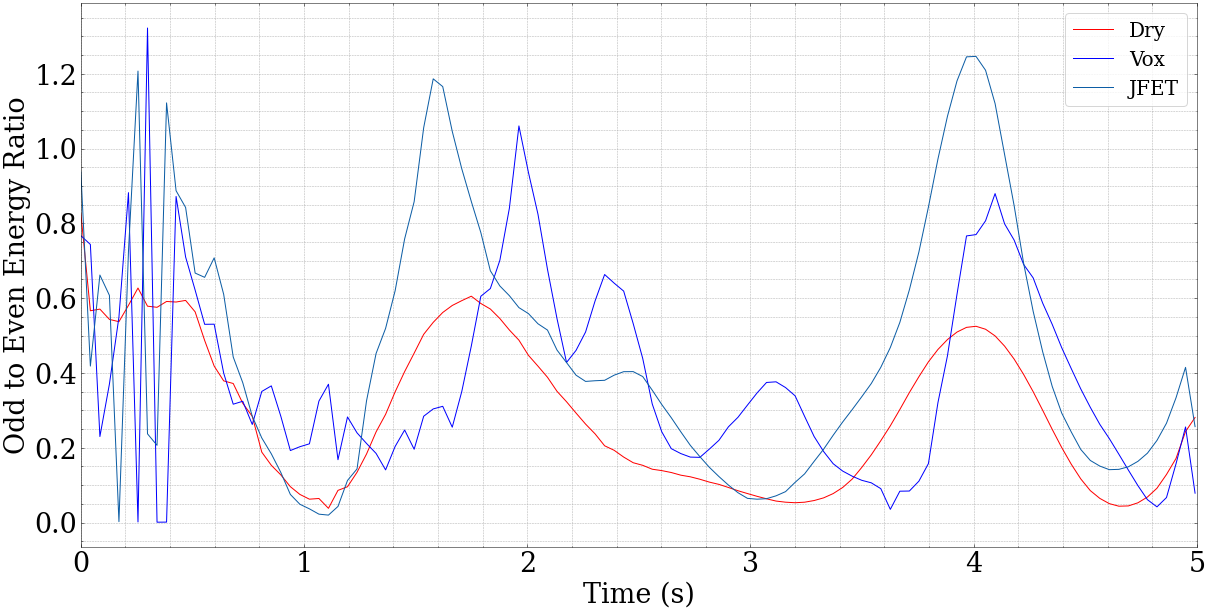

In [121]:
plot_OER(OER_Dry_E2_String_Hi, OER_Vox_Hi_Gain_E2_String_Hi, OER_JFET_Hi_Gain_E2_String_Hi )

### E4 String

#### High Intensity

In [109]:
OER_Dry_E4_String_Hi = OddEvenRatio(Dry_E4_String_Hi, 330)

In [110]:
OER_Vox_Hi_Gain_E4_String_Hi = OddEvenRatio(Vox_Hi_Gain_E4_String_Hi, 330)

In [111]:
OER_JFET_Hi_Gain_E4_String_Hi = OddEvenRatio(JFET_Hi_Gain_E4_String_Hi, 330)

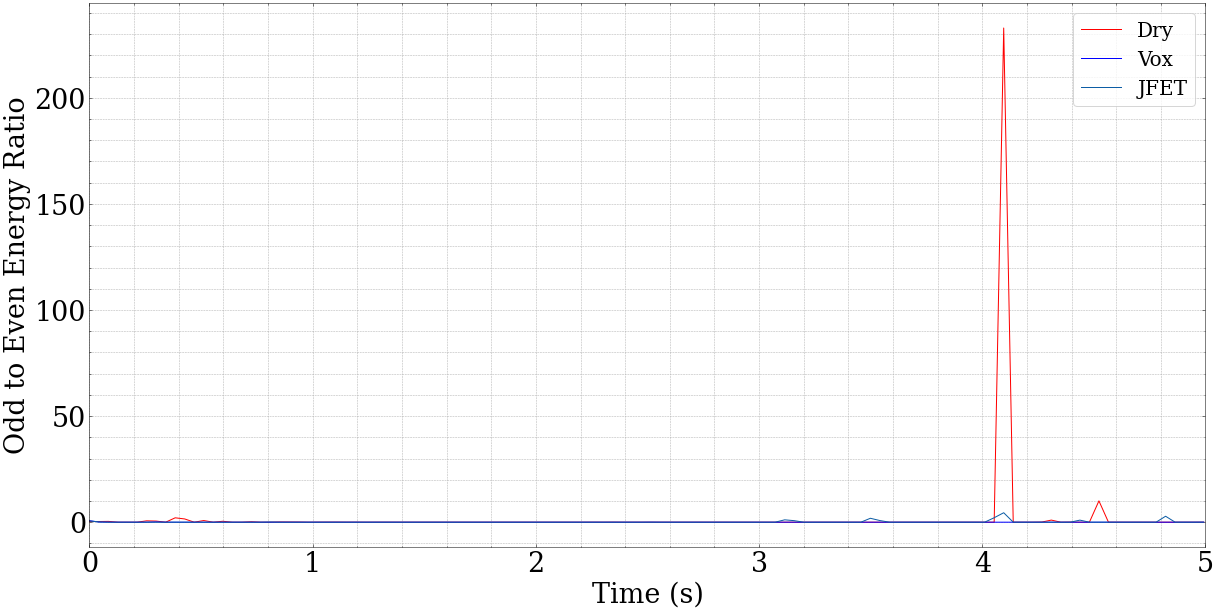

In [113]:
plot_OER(OER_Dry_E4_String_Hi, OER_Vox_Hi_Gain_E4_String_Hi, OER_JFET_Hi_Gain_E4_String_Hi )

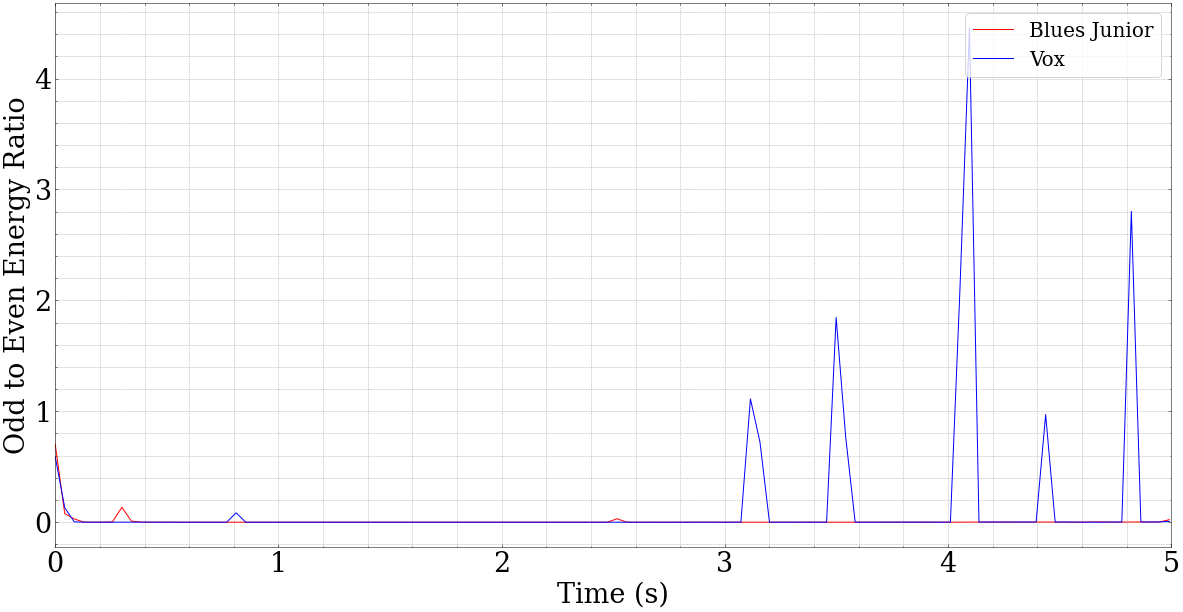

In [115]:
STFT = librosa.stft(Dry_E2_String_Hi, n_fft=FRAME_SIZE)
frames= range(len(STFT.T))
t= librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 27})

plt.plot(t, OER_Vox_Hi_Gain_E4_String_Hi, color="red", linewidth=1, label="Blues Junior" )

plt.plot(t, OER_JFET_Hi_Gain_E4_String_Hi, color="b",linewidth=1, label="Vox" )

# plt.plot(t, OER_VT40Vox,linewidth=1, label="VT40 Vox" )

# plt.plot(t, OER_VT40Marsh,linewidth=1, label="VT40 UK Rock" )

# plt.plot(t, OER_Cali,linewidth=1, label="VT40 US2x12" )

# plt.plot(t, OER_VT40Mesa, color="darkred", linewidth=1, label="VT40 US Metal" )

#plt.title("Odd to Even Harmonic Energy ratio")
plt.ylabel("Odd to Even Energy Ratio")
plt.xlabel('Time (s)')
plt.grid(True, which="both", linestyle='--')

#plt.ylim(0,7)
plt.xlim(0, 5)
#plt.legend()
plt.legend(fontsize=20, frameon=True, loc='upper right' )
plt.show()

In [ ]:
get_harmonics()

### D3 String

#### High Intensity

In [ ]:
OER_Dry_D3_String_Hi = OddEvenRatio(Dry_D3_String_Hi)

In [ ]:
OER_Vox_Hi_Gain_D3_String_Hi = OddEvenRatio(Vox_Hi_Gain_D3_String_Hi)

In [ ]:
OER_JFET_Hi_Gain_D3_String_Hi = OddEvenRatio(JFET_Hi_Gain_D3_String_Hi)

### Amp Comaprisons

In [74]:
# OER_Vox = OddEvenRatio(Vox_Med_Gain_E2_String_Hi)

In [75]:
# OER_VT40Vox = OddEvenRatio(VT40_AC15_E2_String_Hi) 

In [42]:
OER_BluesJnr = OddEvenRatio(BluesJnr_E2_String_Hi)

In [77]:
# OER_Cali = OddEvenRatio(VT40_Cali_E2_String_Hi)

In [78]:
# OER_VT40Marsh = OddEvenRatio(VT40_UKRock_E2_String_Hi)

In [79]:
# OER_VT40Mesa = OddEvenRatio(VT40_USMetal_E2_String_Hi)

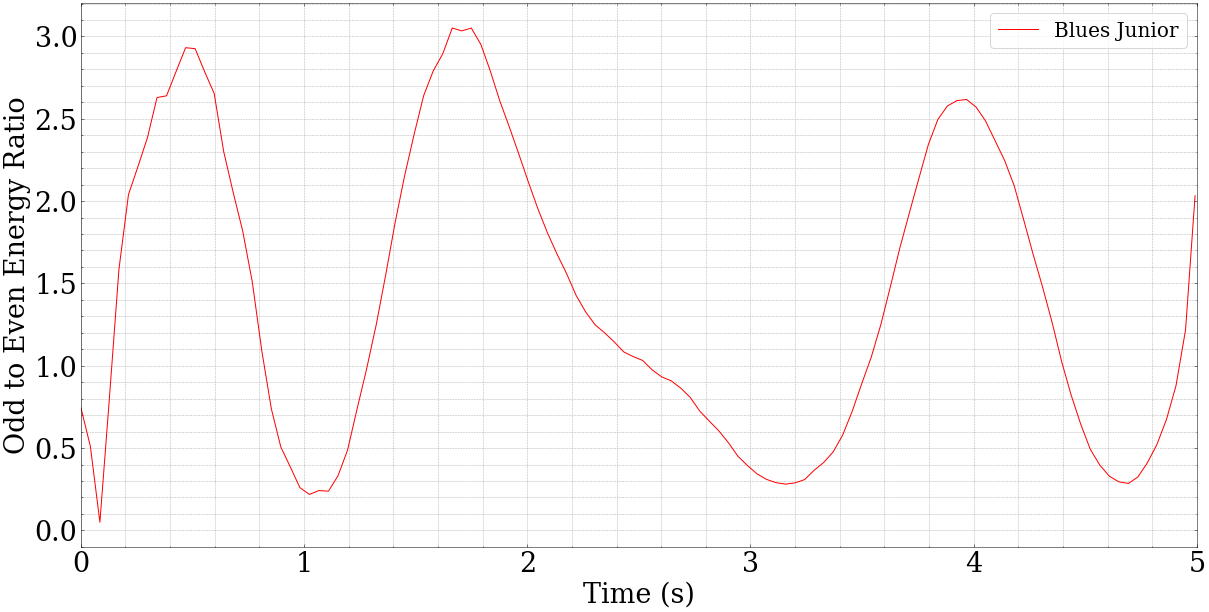

In [43]:
STFT = librosa.stft(Dry_E2_String_Hi, n_fft=FRAME_SIZE)
frames= range(len(STFT.T))
t= librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 27})

plt.plot(t, OER_BluesJnr, color="red", linewidth=1, label="Blues Junior" )

# plt.plot(t, OER_Vox, color="b",linewidth=1, label="Vox" )

# plt.plot(t, OER_VT40Vox,linewidth=1, label="VT40 Vox" )

# plt.plot(t, OER_VT40Marsh,linewidth=1, label="VT40 UK Rock" )

# plt.plot(t, OER_Cali,linewidth=1, label="VT40 US2x12" )

# plt.plot(t, OER_VT40Mesa, color="darkred", linewidth=1, label="VT40 US Metal" )

#plt.title("Odd to Even Harmonic Energy ratio")
plt.ylabel("Odd to Even Energy Ratio")
plt.xlabel('Time (s)')
plt.grid(True, which="both", linestyle='--')

#plt.ylim(0,7)
plt.xlim(0, 5)
#plt.legend()
plt.legend(fontsize=20, frameon=True, loc='upper right' )
plt.show()

## Chords

### E Chord

#### High Intensity

In [123]:
OER_Dry_E_Chord_Hi = OddEvenRatio(Dry_E_Chord_Hi, 82)

In [124]:
OER_Vox_Hi_Gain_E_Chord_Hi = OddEvenRatio(Vox_Hi_Gain_E_Chord_Hi, 82)

In [125]:
OER_JFET_Hi_Gain_E_Chord_Hi = OddEvenRatio(JFET_Hi_Gain_E_Chord_Hi, 82)

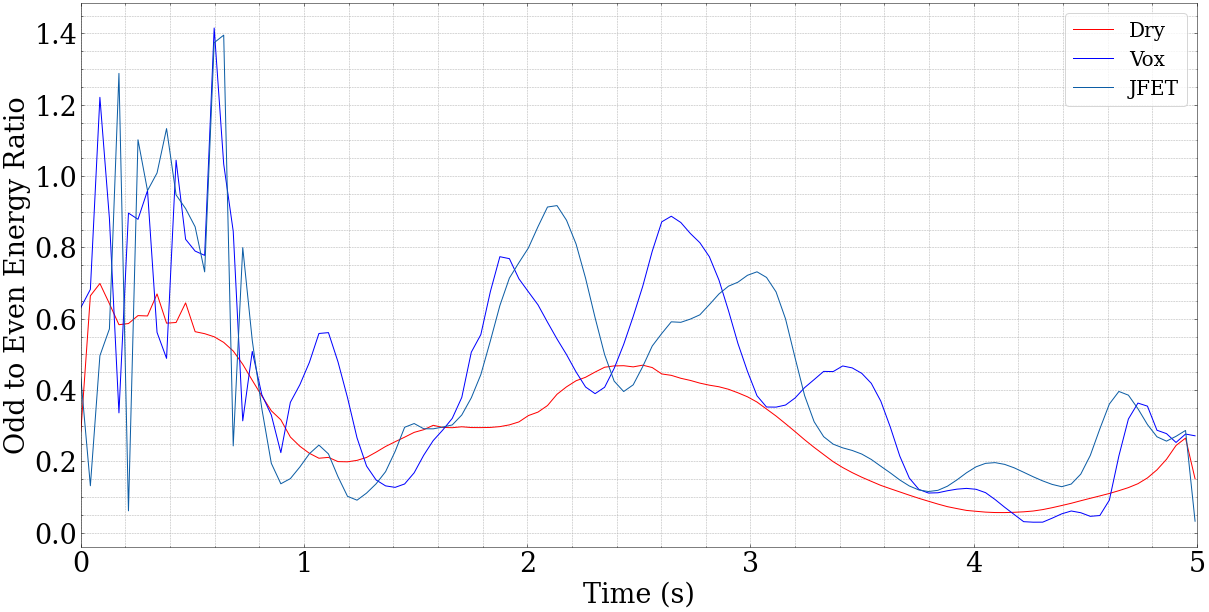

In [126]:
plot_OER(OER_Dry_E_Chord_Hi, OER_Vox_Hi_Gain_E_Chord_Hi, OER_JFET_Hi_Gain_E_Chord_Hi )

### D Chord

#### High Intensity

In [127]:
OER_Dry_D_Chord_Hi = OddEvenRatio(Dry_D_Chord_Hi, 147)

In [128]:
OER_Vox_Hi_Gain_D_Chord_Hi = OddEvenRatio(Vox_Hi_Gain_D_Chord_Hi, 147)

In [129]:
OER_JFET_Hi_Gain_D_Chord_Hi = OddEvenRatio(JFET_Hi_Gain_D_Chord_Hi, 147)

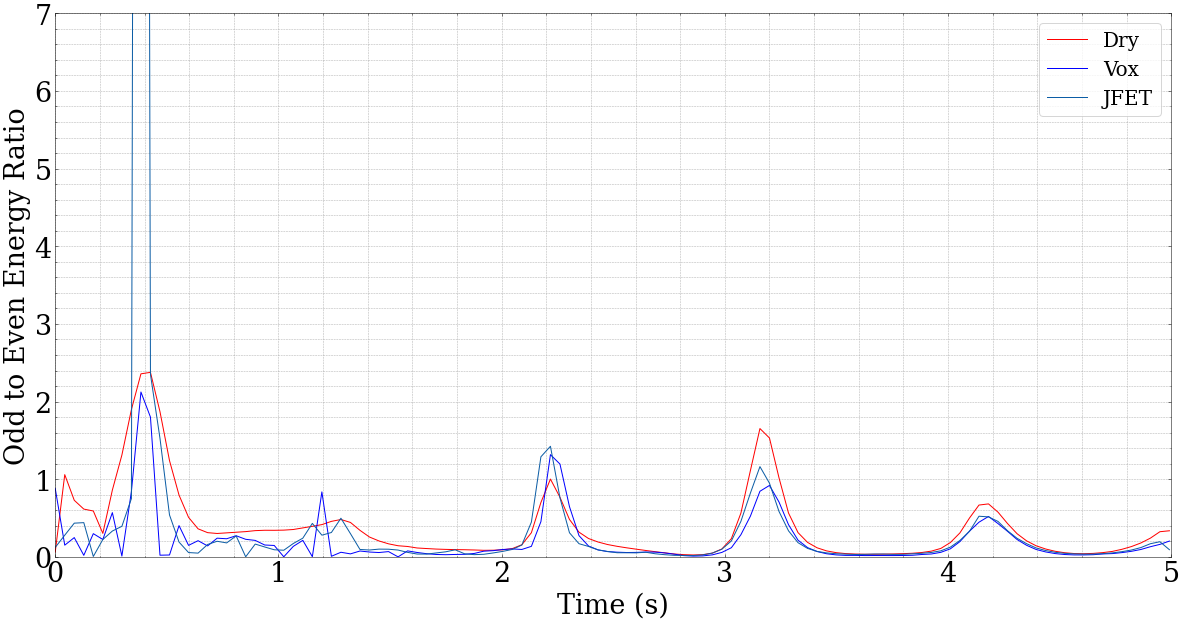

In [132]:
plot_OER(OER_Dry_D_Chord_Hi, OER_Vox_Hi_Gain_D_Chord_Hi, OER_JFET_Hi_Gain_D_Chord_Hi )

# Spectral Deviation

In [236]:
def plot_SpecDev(specDev):
    STFT = librosa.stft(Dry_E2_String_Hi, n_fft=FRAME_SIZE)
    frames= range(len(STFT.T))
    t= librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

    plt.figure(figsize=(20, 10))
    plt.rcParams.update({'font.size': 15})

    plt.plot(t, specDev[0], linewidth=2, label="2nd Harmonic" )
    plt.plot(t, specDev[1], linewidth=2, label="3rd Harmonic" )
    plt.plot(t, specDev[2], linewidth=2, label="4th Harmonic" )
    plt.plot(t, specDev[3], linewidth=2, label="5th Harmonic" )

    #plt.title("Odd to Even Harmonic Energy ratio")
    plt.ylabel("Harmonic to Fundamental Ratio")
    plt.xlabel('Time (s)')
    
    plt.legend(fontsize=20, frameon=True)
    plt.grid(True, which="both", linestyle='--')
    plt.ylim(0,1)
    plt.xlim(0, 5)
    plt.legend()
    #plt.semilogy()
    plt.show()

In [237]:
def Harm_deviation(Signal):
    sign = (librosa.stft(Signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))
    harm2_ratioList = []
    harm3_ratioList = []
    harm4_ratioList = []
    harm5_ratioList = []
    onset = librosa.onset.onset_detect(Signal, sr=sr, hop_length=HOP_SIZE)
    for i in range(onset[0],len(sign.T)):
        peaks = Salience_peaks(Signal, i)
        harms,_, _, fund = get_harmonics2(peaks, 82)
        Fund_energy = np.abs(sign[14][i])
        harm2_Energy_frame = np.abs(sign[harms[0]][i])
        harm3_Energy_frame = np.abs(sign[harms[1]][i])
        harm4_Energy_frame = np.abs(sign[harms[2]][i])
        harm5_Energy_frame = np.abs(sign[harms[3]][i])
  
        harm2_E_ratio = harm2_Energy_frame/Fund_energy
        harm3_E_ratio = harm3_Energy_frame/Fund_energy
        harm4_E_ratio = harm4_Energy_frame/Fund_energy
        harm5_E_ratio = harm5_Energy_frame/Fund_energy


        harm2_ratioList.append(harm2_E_ratio)
        harm3_ratioList.append(harm3_E_ratio)
        harm4_ratioList.append(harm4_E_ratio)
        harm5_ratioList.append(harm5_E_ratio)
        
    for o in range(onset[0]):
        harm2_ratioList.insert(0,np.nan)
        harm3_ratioList.insert(0,np.nan)
        harm4_ratioList.insert(0,np.nan)
        harm5_ratioList.insert(0,np.nan)
            
    return [harm2_ratioList, harm3_ratioList, harm4_ratioList, harm5_ratioList]


In [238]:
def Harm_deviation2(Signal,fundamental):
    sign = np.abs((librosa.stft(Signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))) ** 2
    harm2_ratioList = []
    harm3_ratioList = []
    harm4_ratioList = []
    harm5_ratioList = []
    onset = librosa.onset.onset_detect(Signal, sr=sr, hop_length=HOP_SIZE)
    for i in range( len(sign.T)):
        peaks = Salience_peaks(Signal, i)
        harms, _, _, fund = get_harmonics2(peaks, fundamental)
        Fund_energy = np.abs(sign[fund[0]][i])
        harm2_Energy_frame = np.abs(sign[harms[0]][i])
        harm3_Energy_frame = np.abs(sign[harms[1]][i])
        harm4_Energy_frame = np.abs(sign[harms[2]][i])
        harm5_Energy_frame = np.abs(sign[harms[3]][i])
  
        harm2_E_ratio = harm2_Energy_frame/Fund_energy
        harm3_E_ratio = harm3_Energy_frame/Fund_energy
        harm4_E_ratio = harm4_Energy_frame/Fund_energy
        harm5_E_ratio = harm5_Energy_frame/Fund_energy


        harm2_ratioList.append(harm2_E_ratio)
        harm3_ratioList.append(harm3_E_ratio)
        harm4_ratioList.append(harm4_E_ratio)
        harm5_ratioList.append(harm5_E_ratio)
        
#     for o in range(onset[0]):
#         harm2_ratioList.insert(0,np.nan)
#         harm3_ratioList.insert(0,np.nan)
#         harm4_ratioList.insert(0,np.nan)
#         harm5_ratioList.insert(0,np.nan)
            
    return [harm2_ratioList, harm3_ratioList, harm4_ratioList, harm5_ratioList]


In [239]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=1):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft) 

    #plot mag spectrum
    plt.figure(figsize=(18,5))
    
    frequency = np.linspace(0, sr, len(magnitude_spectrum))
    no_freq_bins = int(len(frequency)*f_ratio)
    
    plt.plot(frequency[:no_freq_bins], magnitude_spectrum[:no_freq_bins])
    plt.title(title)
    plt.xlabel("Frequency(Hz)")
    
    plt.show()

In [522]:
Dry_HSD = Harm_deviation(Dry_E2_String_Hi)

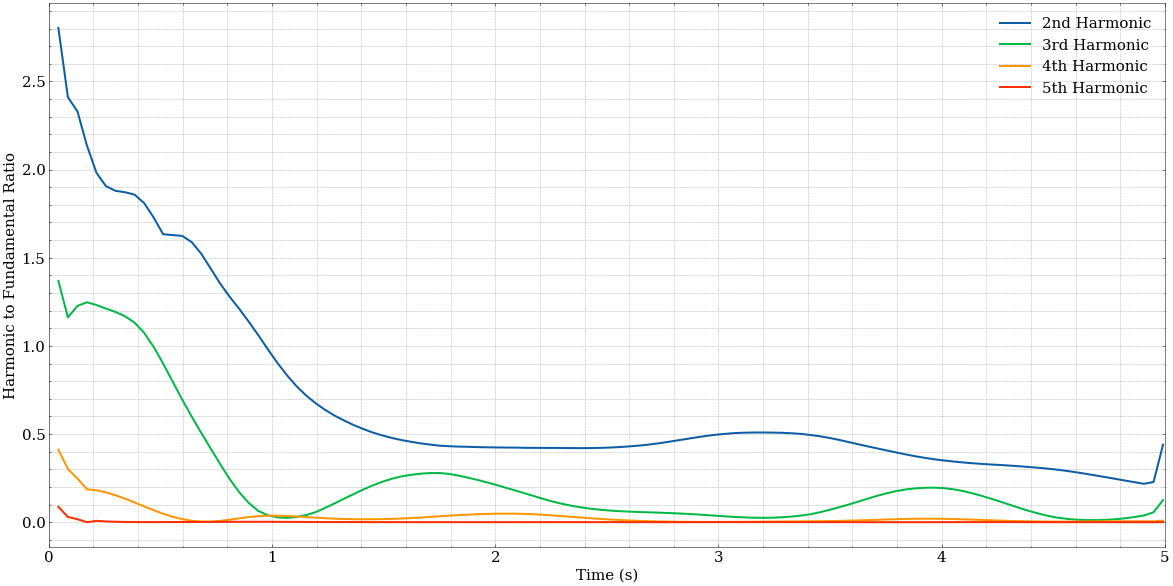

In [523]:
plot_SpecDev(Dry_HSD)

In [526]:
Dry_HSD = Harm_deviation2(Dry_E2_String_Hi)

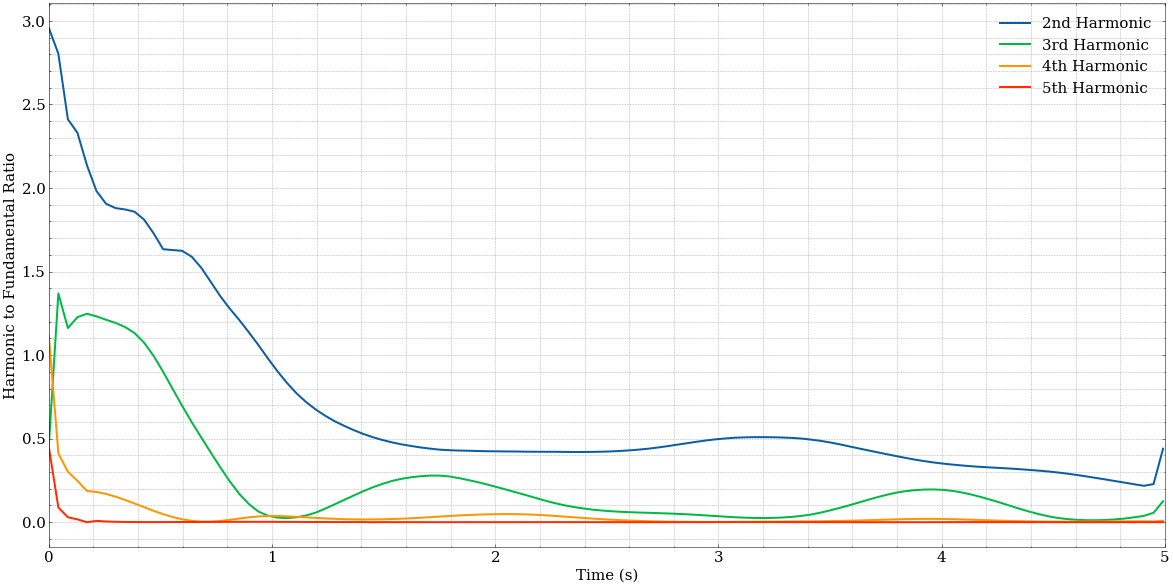

In [527]:
plot_SpecDev(Dry_HSD)

In [560]:
Vox_HSD = Harm_deviation(Vox_Med_Gain_E2_String_Hi)

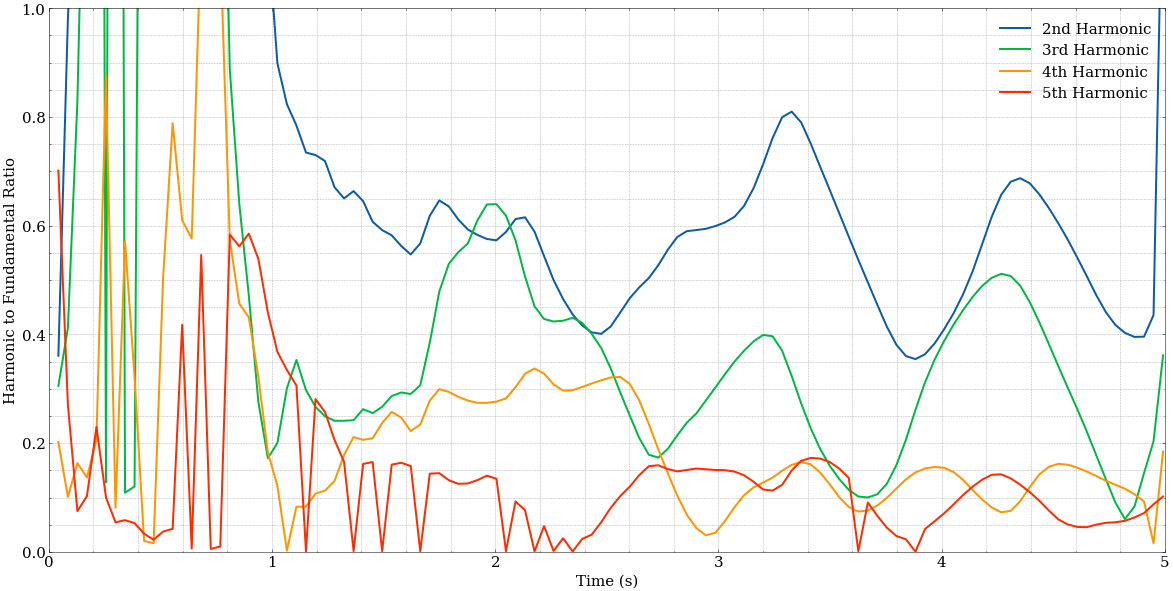

In [561]:
plot_SpecDev(Vox_HSD)

In [562]:
JFET_HSD = Harm_deviation(JFET_Med_Gain_E2_String_Hi)

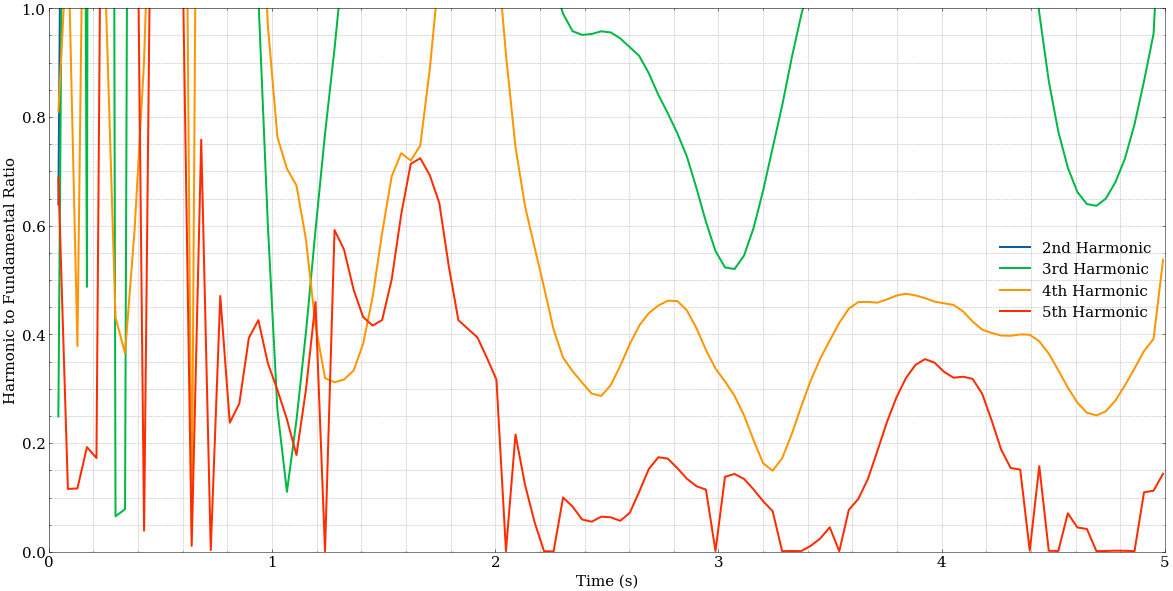

In [563]:
plot_SpecDev(JFET_HSD)

In [586]:
Harm_Test = Harm_deviation2(Test_fiveHarms, 82)

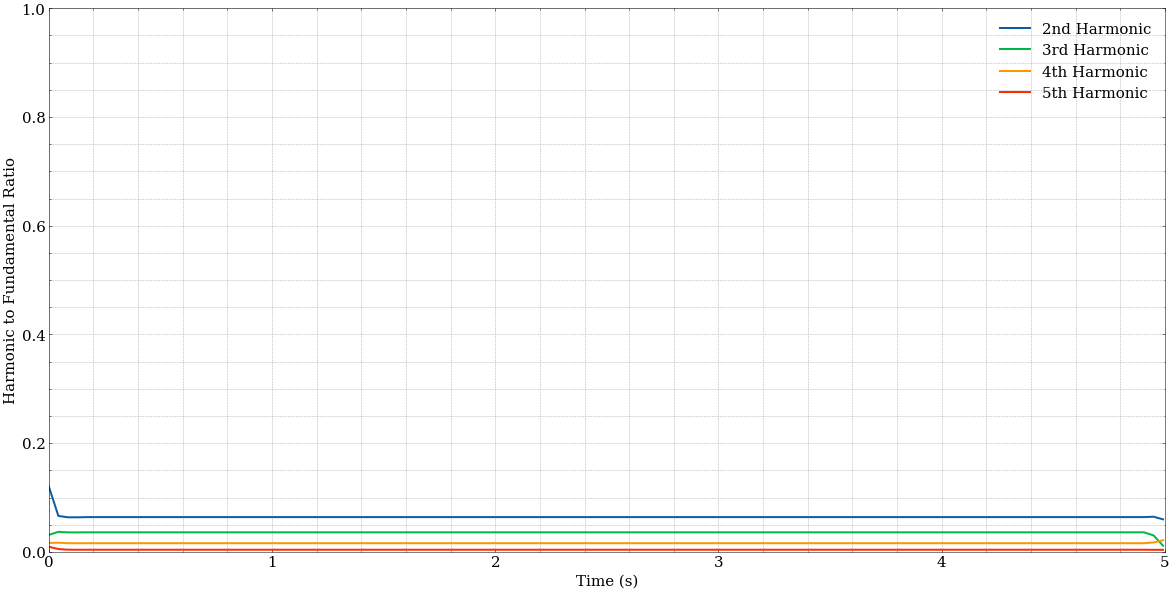

In [587]:
plot_SpecDev(Harm_Test)

# SpecDev Proper

## Functions

In [534]:
def SpectralDeviation( Signal ,fundamental):
    sign = (librosa.stft(Signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))
#     onset = librosa.onset.onset_detect(Signal, sr=sr, hop_length=HOP_SIZE)
    
#     spec_dev_frame=[]
#     Spec_Dev = []
#     for i in range( len(sign.T)):
#         peaks = Salience_peaks(Signal, i)
#         harms, _, _, fund = get_harmonics2(peaks, fundamental)
#         for h in range(len(harms)-1):
#             previous_harm = np.abs(sign[harms[h-1],[i]])
#             current_harm = np.abs(sign[harms[h],[i]])
#             next_harm = np.abs(sign[harms[h+1],[i]])
#             Spectral_env = (1/3)*(previous_harm + current_harm + next_harm)
            
#             spec_dev_frame += (current_harm - Spectral_env)
            
#         Spec_Dev.append(spec_dev_frame)  
        
  
    Spec_Dev = []
    for i in range(len(sign.T)):
        spec_dev_frame=0
        peaks = Salience_peaks(Signal, i)
        harms, _, _, fund = get_harmonics2(peaks, fundamental)
        for h in range(len(harms)-1):
            if h == 0:
                if len(fund) == 0:
                    previous_harm = np.abs(sign[14][i])
                else:
                    previous_harm = np.abs(sign[fund[0]][i])
            else:
                previous_harm = np.abs(sign[harms[h-1]][i])

            current_harm = np.abs(sign[harms[h]][i])
            next_harm = np.abs(sign[harms[h+1]][i])

            Spectral_env = (previous_harm + current_harm + next_harm)/3

            spec_dev_frame += (current_harm - Spectral_env)

        Spec_Dev.append(spec_dev_frame)      
          
    return Spec_Dev

In [547]:
def OER_error(Sig_compare, Sig_ref, Frame_Size=FRAME_SIZE, Hop_length=HOP_SIZE, sr=48000):
    #SC_Sig_compare = librosa.feature.spectral_centroid(Sig_compare, sr=sr, n_fft=Frame_Size, hop_length=Hop_length)[0]
    #SC_Sig_ref     = librosa.feature.spectral_centroid(Sig_ref, sr=sr, n_fft=Frame_Size, hop_length=Hop_length)[0]
    
    frame_1s = librosa.time_to_frames(1, hop_length=HOP_SIZE, sr=sr )
    frame_2s = librosa.time_to_frames(2, hop_length=HOP_SIZE, sr=sr )
    frame_3s = librosa.time_to_frames(3, hop_length=HOP_SIZE, sr=sr )
    frame_4s = librosa.time_to_frames(4, hop_length=HOP_SIZE, sr=sr )
    frame_5s = librosa.time_to_frames(5, hop_length=HOP_SIZE, sr=sr )
    
    cum_ratio = 0
    
    for i in range(len(Sig_ref)):
        cum_ratio += ((Sig_compare[i]/Sig_ref[i]) - 1)

        if i == (frame_1s):
            ratio0_1 = cum_ratio
        if i == (frame_2s):
            ratio1_2 = cum_ratio - ratio0_1
        if i == (frame_3s):
            ratio2_3 = cum_ratio - ratio1_2 - ratio0_1
        if i == (frame_4s):
            ratio3_4 = cum_ratio - ratio2_3 - ratio1_2 - ratio0_1
        if i == (frame_5s):
            ratio4_5 = cum_ratio - ratio3_4 - ratio2_3 - ratio1_2 - ratio0_1

    average0_1sec = ratio0_1/(frame_1s+1) * 100
    average1_2sec = ratio1_2/(frame_1s+1) * 100
    average2_3sec = ratio2_3/(frame_1s+1) * 100
    average3_4sec = ratio3_4/(frame_1s+1) * 100
    average4_5sec = ratio4_5/(frame_1s+1) * 100
    
    average0_1sec = round(average0_1sec,2)
    average1_2sec = round(average1_2sec,2)
    average2_3sec = round(average2_3sec,2)
    average3_4sec = round(average3_4sec,2)
    average4_5sec = round(average4_5sec,2)
    
    average_tot = cum_ratio/(len(Sig_ref)+1) * 100
    average_tot = round(average_tot,2)
    
    return [average0_1sec, average1_2sec, average2_3sec, average3_4sec, average4_5sec, average_tot]

In [565]:
def OER_error_diff(Sig_compare, Sig_ref, Frame_Size=FRAME_SIZE, Hop_length=HOP_SIZE, sr=48000):
    #SC_Sig_compare = librosa.feature.spectral_centroid(Sig_compare, sr=sr, n_fft=Frame_Size, hop_length=Hop_length)[0]
    #SC_Sig_ref     = librosa.feature.spectral_centroid(Sig_ref, sr=sr, n_fft=Frame_Size, hop_length=Hop_length)[0]
    
    frame_1s = librosa.time_to_frames(1, hop_length=HOP_SIZE, sr=sr )
    frame_2s = librosa.time_to_frames(2, hop_length=HOP_SIZE, sr=sr )
    frame_3s = librosa.time_to_frames(3, hop_length=HOP_SIZE, sr=sr )
    frame_4s = librosa.time_to_frames(4, hop_length=HOP_SIZE, sr=sr )
    frame_5s = librosa.time_to_frames(5, hop_length=HOP_SIZE, sr=sr )
    
    cum_ratio = 0
    
    for i in range(len(Sig_ref)):
        cum_ratio += ((Sig_compare[i] - Sig_ref[i]))

        if i == (frame_1s):
            ratio0_1 = cum_ratio
        if i == (frame_2s):
            ratio1_2 = cum_ratio - ratio0_1
        if i == (frame_3s):
            ratio2_3 = cum_ratio - ratio1_2 - ratio0_1
        if i == (frame_4s):
            ratio3_4 = cum_ratio - ratio2_3 - ratio1_2 - ratio0_1
        if i == (frame_5s):
            ratio4_5 = cum_ratio - ratio3_4 - ratio2_3 - ratio1_2 - ratio0_1

    average0_1sec = ratio0_1/(frame_1s+1) * 100
    average1_2sec = ratio1_2/(frame_1s+1) * 100
    average2_3sec = ratio2_3/(frame_1s+1) * 100
    average3_4sec = ratio3_4/(frame_1s+1) * 100
    average4_5sec = ratio4_5/(frame_1s+1) * 100
    
    average0_1sec = round(average0_1sec,2)
    average1_2sec = round(average1_2sec,2)
    average2_3sec = round(average2_3sec,2)
    average3_4sec = round(average3_4sec,2)
    average4_5sec = round(average4_5sec,2)
    
    average_tot = cum_ratio/(len(Sig_ref)+1) * 100
    average_tot = round(average_tot,2)
    
    return [average0_1sec, average1_2sec, average2_3sec, average3_4sec, average4_5sec, average_tot]

In [533]:
freqs[14]

82.03125

In [367]:
specdevVox = SpectralDeviation(Vox_Med_Gain_E_Chord_Hi, 82)

In [368]:
specdevDry = SpectralDeviation(Dry_E_Chord_Hi, 82)

In [369]:
specdevJFET = SpectralDeviation(JFET_Med_Gain_E_Chord_Hi, 82)

In [359]:
len(specdevVox)

118

In [410]:
def plot_SpectralDeviation(specDev1, specDev2, specDev3):
    STFT = librosa.stft(Dry_E2_String_Hi, n_fft=FRAME_SIZE)
    frames= range(len(STFT.T))
    t= librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

    plt.figure(figsize=(20, 10))
    plt.rcParams.update({'font.size': 27})

    plt.plot(t, specDev1, linewidth=2, label="vox")
    plt.plot(t, specDev2, linewidth=2, label="JFET")
    plt.plot(t, specDev3, linewidth=2, label="DRY")
            
   
    #plt.title("Odd to Even Harmonic Energy ratio")
    plt.ylabel("Harmonic Spectral Deviation")
    plt.xlabel('Time (s)')
    
    plt.legend(fontsize=20, frameon=True)
    plt.grid(True, which="both", linestyle='--')
    #plt.ylim(0,1)
    plt.xlim(0, 5)
    plt.legend()
    #plt.semilogy()
    plt.show()

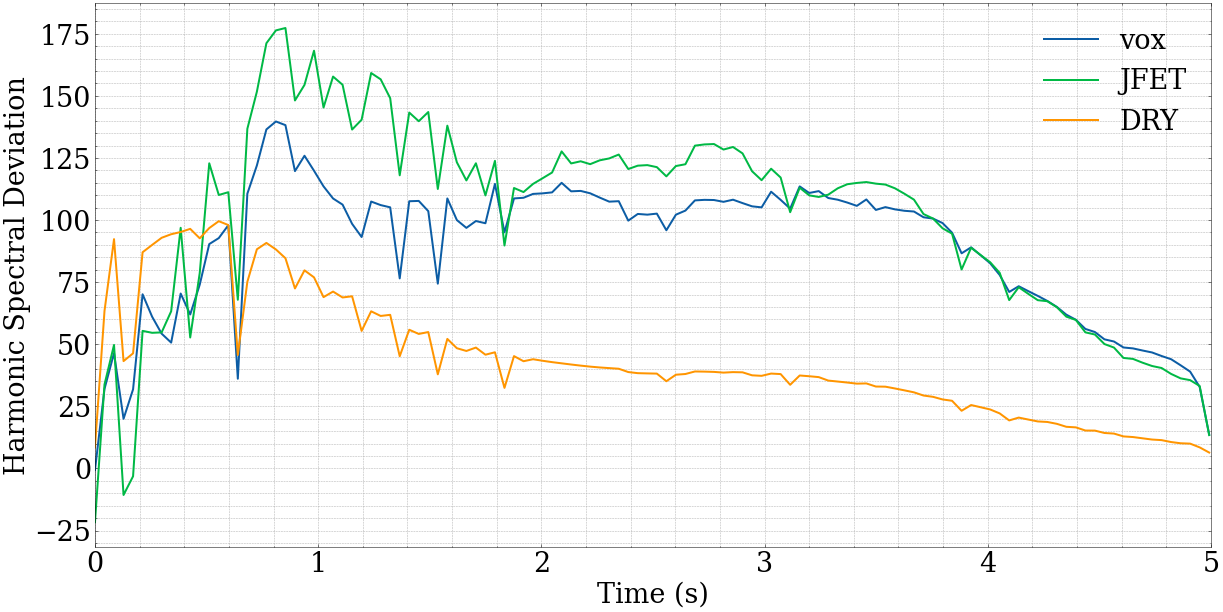

In [411]:
plot_SpectralDeviation(specdevVox,specdevJFET,specdevDry)

In [505]:
HSD_BluesJnr_E_Chord_Hi = SpectralDeviation(BluesJnr_E_Chord_Hi, 82)

In [506]:
HSD_VT40_AC15_E_Chord_Hi = SpectralDeviation(VT40_AC15_E_Chord_Hi, 82)

In [507]:
HSD_VT40_UKRock_E_Chord_Hi = SpectralDeviation(VT40_UKRock_E_Chord_Hi, 82)

In [508]:
HSD_VT40_Cali_E_Chord_Hi = SpectralDeviation(VT40_Cali_E_Chord_Hi, 82)

In [509]:
HSD_VT40_USMetal_E_Chord_Hi = SpectralDeviation(VT40_USMetal_E_Chord_Hi, 82)

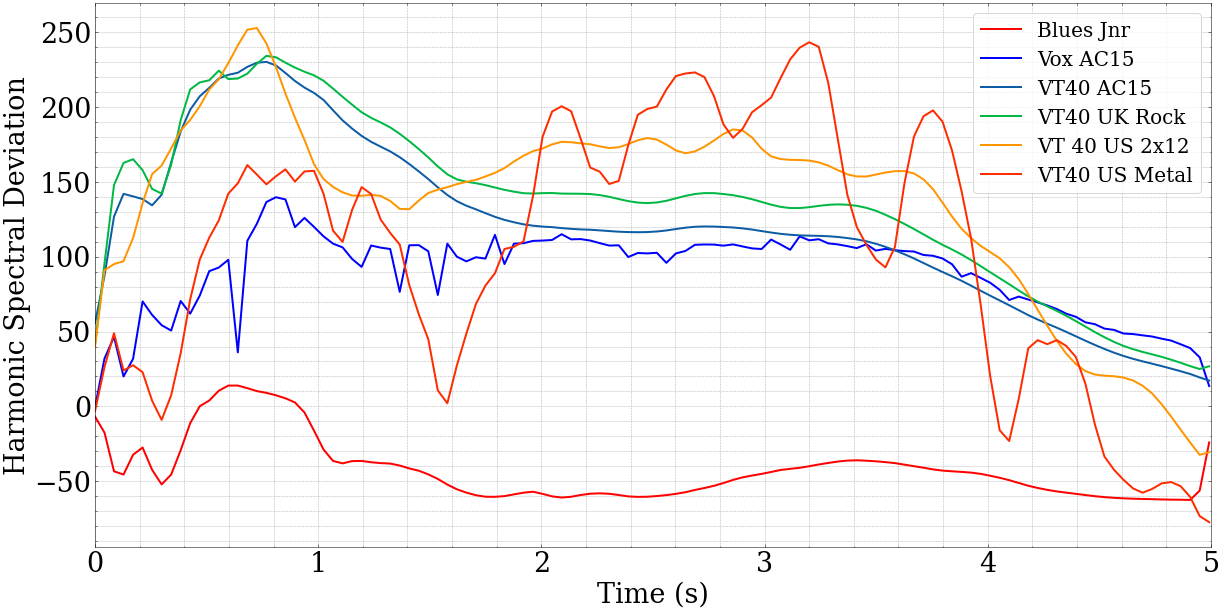

In [521]:
STFT = librosa.stft(Dry_E2_String_Hi, n_fft=FRAME_SIZE)
frames= range(len(STFT.T))
t= librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE)

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 27})

plt.plot(t, HSD_BluesJnr_E_Chord_Hi, color='red', label="Blues Jnr", linewidth=2 )

plt.plot(t, specdevVox, color='b', label="Vox AC15", linewidth=2 )

plt.plot(t, HSD_VT40_AC15_E_Chord_Hi, label="VT40 AC15", linewidth=2 )

#plt.plot(t, specdevDry, color='r',  label="Dry")

plt.plot(t, HSD_VT40_UKRock_E_Chord_Hi,  label="VT40 UK Rock", linewidth=2)

plt.plot(t, HSD_VT40_Cali_E_Chord_Hi,  label="VT 40 US 2x12", linewidth=2)

plt.plot(t, HSD_VT40_USMetal_E_Chord_Hi, label="VT40 US Metal", linewidth=2)

#plt.plot(t, sc_VoxR, color='b', label="Real Vox" )

plt.legend(fontsize=20, frameon=True)

#plt.title("Spectral Variation of Medium Gain High Intensity E Chord")
plt.ylabel("Harmonic Spectral Deviation")
plt.xlabel('Time (s)')


plt.xlim(0, 5)
#plt.yscale('log')
#plt.yticks(ticks=[0.01, 0.1, 1], labels=[0.01, 0.1, 1])
plt.grid(True, which="both", linestyle='--')
plt.show()

## Chords

### E Chord

#### High Gain

In [494]:
HSD_Dry_E_Chord_Hi = SpectralDeviation(Dry_E_Chord_Hi, 82)

In [495]:
HSD_Vox_Hi_Gain_E_Chord_Hi = SpectralDeviation(Vox_Hi_Gain_E_Chord_Hi, 82)

In [496]:
HSD_JFET_Hi_Gain_E_Chord_Hi = SpectralDeviation(JFET_Hi_Gain_E_Chord_Hi, 82)

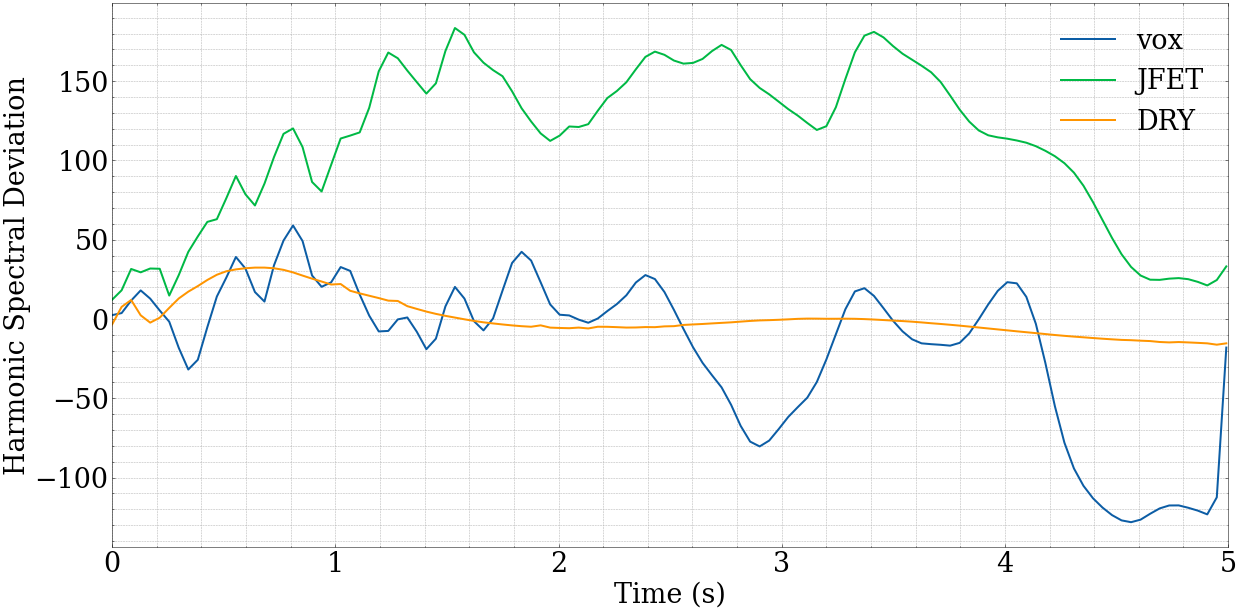

In [497]:
plot_SpectralDeviation(HSD_Vox_Hi_Gain_E_Chord_Hi,HSD_JFET_Hi_Gain_E_Chord_Hi,HSD_Dry_E_Chord_Hi)

In [578]:
OER_error_diff(HSD_Vox_Hi_Gain_E_Chord_Hi, HSD_Dry_E_Chord_Hi)

[-430.54, 519.24, -1394.18, -909.78, -7145.7, -1887.92]

In [579]:
OER_error_diff(HSD_JFET_Hi_Gain_E_Chord_Hi, HSD_Dry_E_Chord_Hi)

[4387.36, 13618.0, 15375.3, 14052.55, 7263.17, 11031.2]

#### Med Gain

In [498]:
HSD_Dry_E_Chord_Hi = SpectralDeviation(Dry_E_Chord_Hi, 82)

In [499]:
HSD_Vox_Med_Gain_E_Chord_Hi = SpectralDeviation(Vox_Med_Gain_E_Chord_Hi, 82)

In [500]:
HSD_JFET_Med_Gain_E_Chord_Hi = SpectralDeviation(JFET_Med_Gain_E_Chord_Hi, 82)

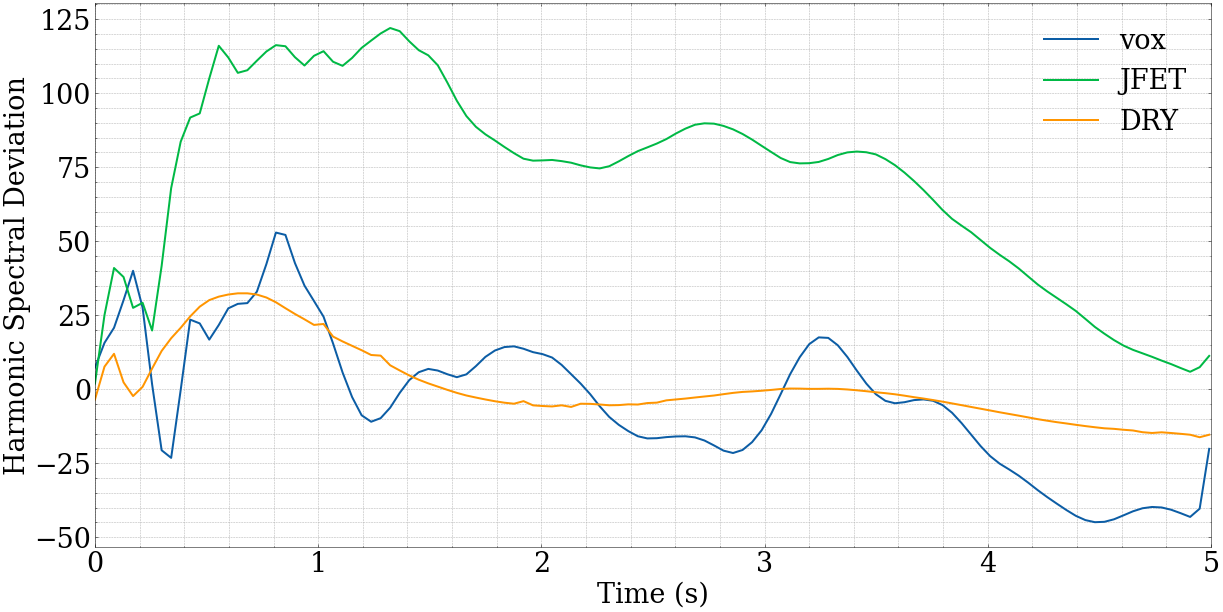

In [501]:
plot_SpectralDeviation(HSD_Vox_Med_Gain_E_Chord_Hi,HSD_JFET_Med_Gain_E_Chord_Hi,HSD_Dry_E_Chord_Hi)

In [580]:
OER_error_diff(HSD_Vox_Med_Gain_E_Chord_Hi, HSD_Dry_E_Chord_Hi)

[333.74, 124.24, -660.01, 199.37, -2494.96, -503.72]

In [581]:
OER_error_diff(HSD_JFET_Med_Gain_E_Chord_Hi, HSD_Dry_E_Chord_Hi)

[5930.6, 9441.3, 8573.77, 7036.65, 3533.72, 6961.22]

#### LowGain

In [502]:
HSD_Vox_Low_Gain_E_Chord_Hi = SpectralDeviation(Vox_Low_Gain_E_Chord_Hi, 82)

In [503]:
HSD_JFET_Low_Gain_E_Chord_Hi = SpectralDeviation(JFET_Low_Gain_E_Chord_Hi, 82)

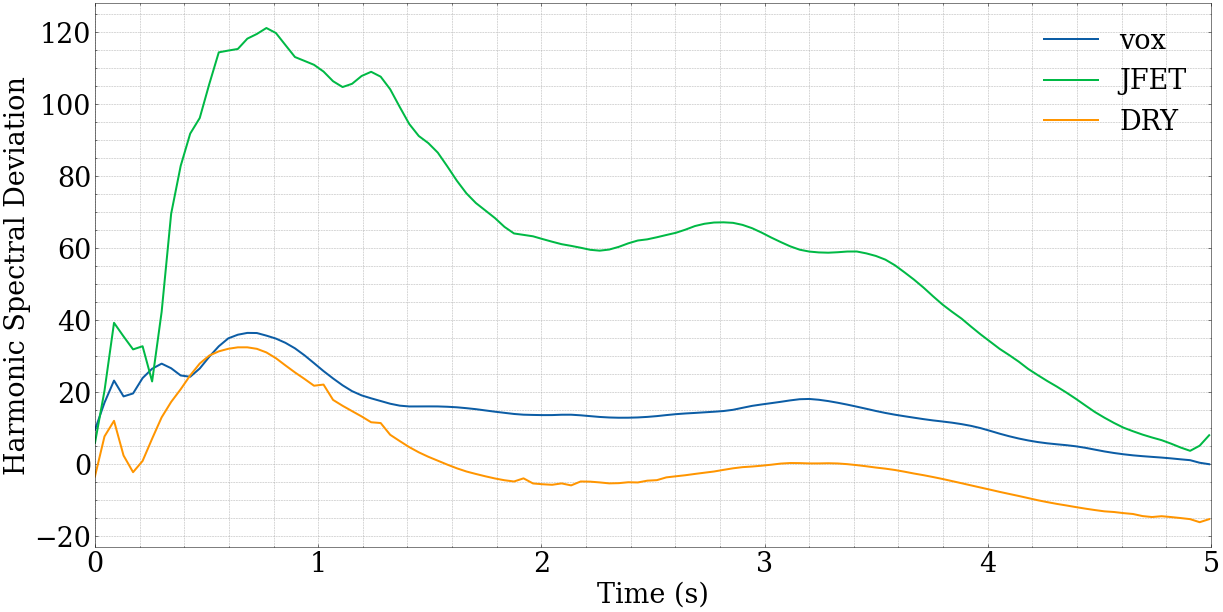

In [504]:
plot_SpectralDeviation(HSD_Vox_Low_Gain_E_Chord_Hi,HSD_JFET_Low_Gain_E_Chord_Hi,HSD_Dry_E_Chord_Hi)

In [582]:
OER_error_diff(HSD_Vox_Low_Gain_E_Chord_Hi, HSD_Dry_E_Chord_Hi)

[801.98, 1212.36, 1772.0, 1577.23, 1638.39, 1412.16]

In [583]:
OER_error_diff(HSD_JFET_Low_Gain_E_Chord_Hi, HSD_Dry_E_Chord_Hi)

[6150.34, 8002.17, 6698.51, 5293.01, 2825.94, 5842.68]

### D Chord

#### High Gain

In [490]:
HSD_Dry_D_Chord_Hi = SpectralDeviation(Dry_D_Chord_Hi, 147)

In [491]:
HSD_Vox_Hi_Gain_D_Chord_Hi = SpectralDeviation(Vox_Hi_Gain_D_Chord_Hi, 147)

In [492]:
HSD_JFET_Hi_Gain_D_Chord_Hi = SpectralDeviation(JFET_Hi_Gain_D_Chord_Hi, 147)

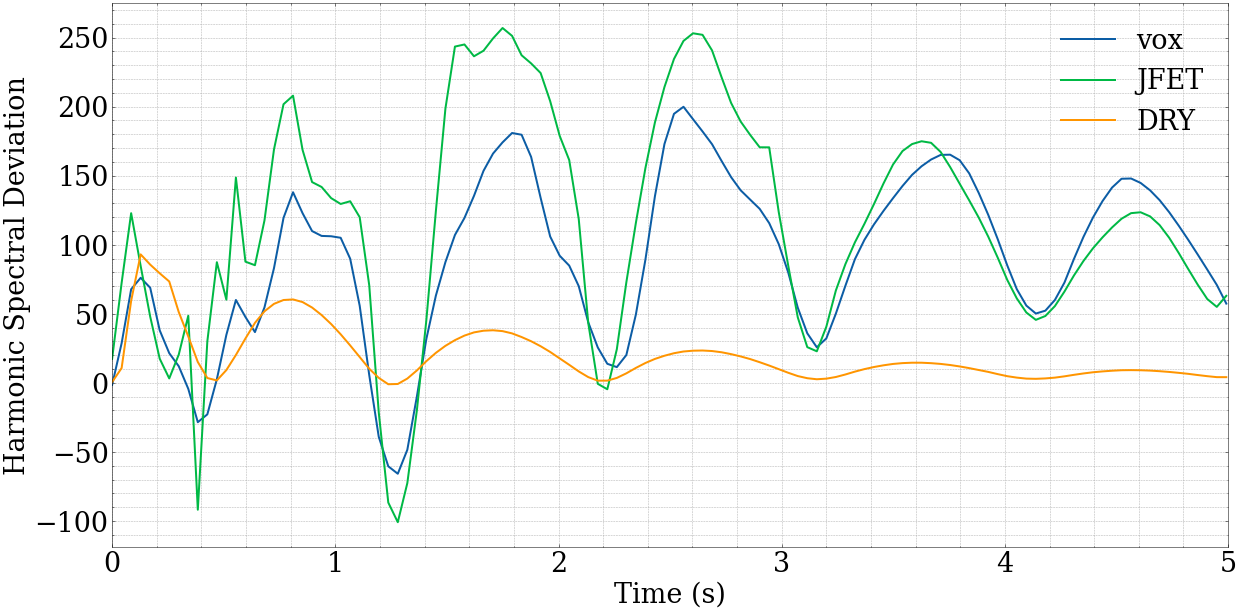

In [493]:
plot_SpectralDeviation(HSD_Vox_Hi_Gain_D_Chord_Hi,HSD_JFET_Hi_Gain_D_Chord_Hi,HSD_Dry_D_Chord_Hi)

In [566]:
OER_error_diff(HSD_Vox_Hi_Gain_D_Chord_Hi, HSD_Dry_D_Chord_Hi)

[965.98, 5425.7, 9678.26, 9643.0, 9329.27, 7067.34]

In [567]:
OER_error_diff(HSD_JFET_Hi_Gain_D_Chord_Hi, HSD_Dry_D_Chord_Hi)

[4507.84, 10857.24, 14180.7, 10043.17, 7773.39, 9552.07]

#### Med Gain

In [511]:
HSD_Dry_D_Chord_Hi = SpectralDeviation(Dry_D_Chord_Hi, 147)

In [512]:
HSD_Vox_Med_Gain_D_Chord_Hi = SpectralDeviation(Vox_Med_Gain_D_Chord_Hi, 147)

In [513]:
HSD_JFET_Med_Gain_D_Chord_Hi = SpectralDeviation(JFET_Med_Gain_D_Chord_Hi, 147)

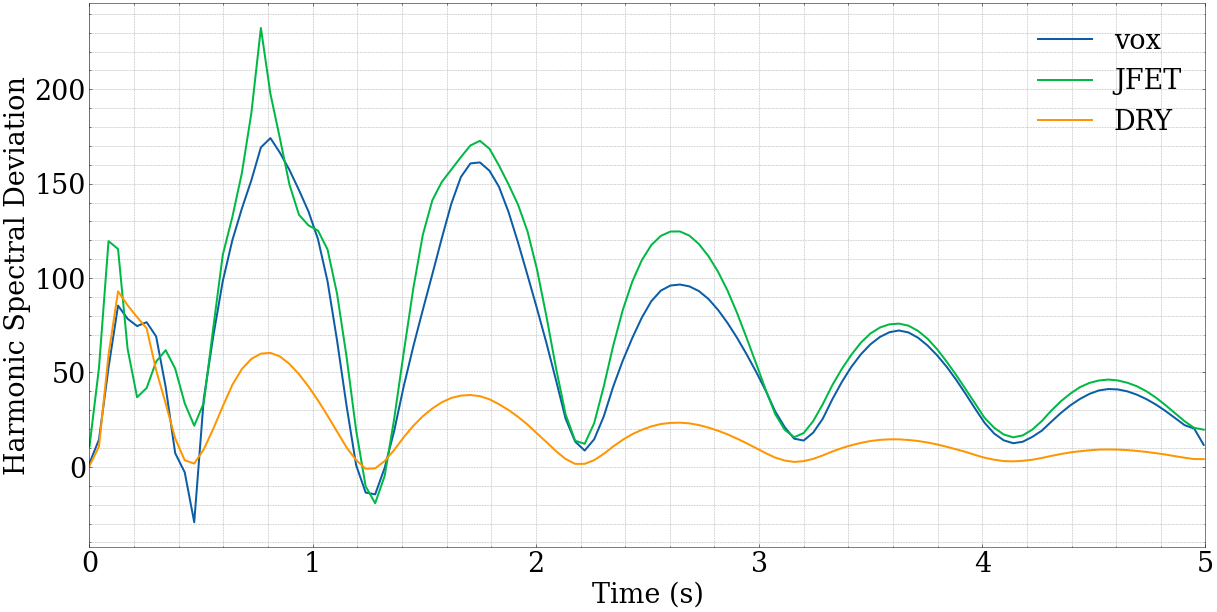

In [514]:
plot_SpectralDeviation(HSD_Vox_Med_Gain_D_Chord_Hi,HSD_JFET_Med_Gain_D_Chord_Hi,HSD_Dry_D_Chord_Hi)

In [584]:
OER_error_diff(HSD_Vox_Med_Gain_D_Chord_Hi, HSD_Dry_D_Chord_Hi)

[4107.29, 6105.61, 4872.42, 3533.03, 2107.75, 4180.06]

In [585]:
OER_error_diff(HSD_JFET_Med_Gain_D_Chord_Hi, HSD_Dry_D_Chord_Hi)

[5536.37, 7685.42, 6681.02, 3893.05, 2534.51, 5310.32]

#### Low Gain

In [515]:
HSD_Dry_D_Chord_Hi = SpectralDeviation(Dry_D_Chord_Hi, 147)

In [516]:
HSD_Vox_Low_Gain_D_Chord_Hi = SpectralDeviation(Vox_Low_Gain_D_Chord_Hi, 147)

In [530]:
HSD_JFET_Low_Gain_D_Chord_Hi = SpectralDeviation(JFET_Low_Gain_D_Chord_Hi, 147)

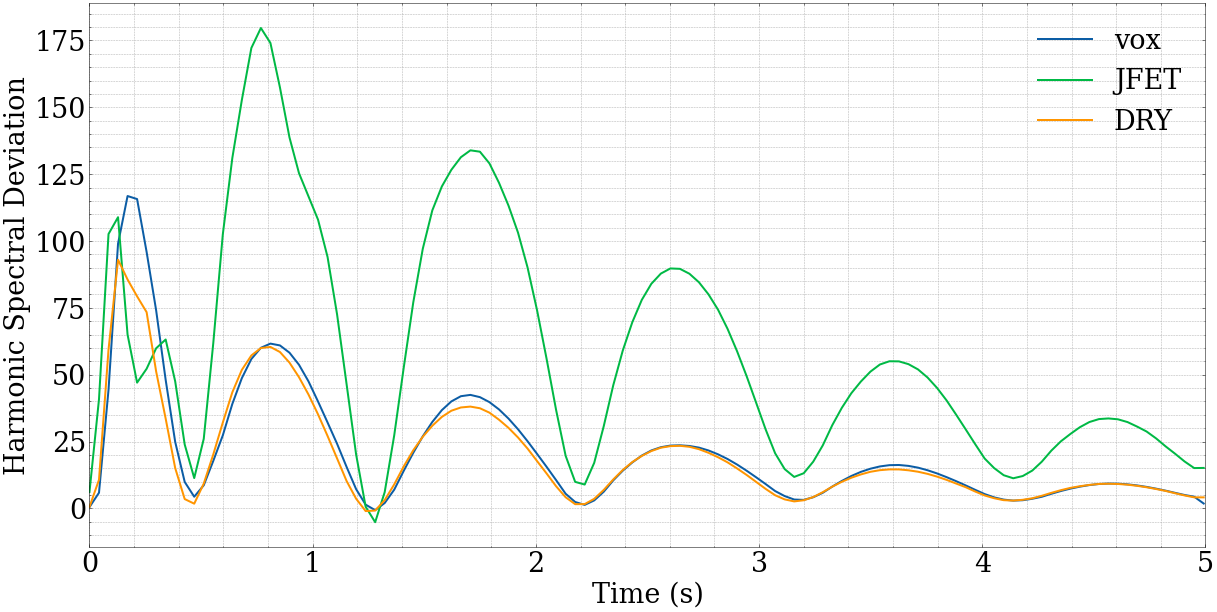

In [531]:
plot_SpectralDeviation(HSD_Vox_Low_Gain_D_Chord_Hi,HSD_JFET_Low_Gain_D_Chord_Hi,HSD_Dry_D_Chord_Hi)

In [586]:
OER_error_diff(HSD_Vox_Low_Gain_D_Chord_Hi, HSD_Dry_D_Chord_Hi)

[553.57, 243.71, 71.16, 90.97, -7.33, 192.02]

In [587]:
OER_error_diff(HSD_JFET_Low_Gain_D_Chord_Hi, HSD_Dry_D_Chord_Hi)

[4669.94, 5746.22, 4371.6, 2567.59, 1662.08, 3835.45]

## Strings

### E2 String

#### High Gain

In [535]:
HSD_Dry_E2_String_Hi = SpectralDeviation(Dry_E2_String_Hi, 82)

In [536]:
HSD_Vox_Hi_Gain_E2_String_Hi = SpectralDeviation(Vox_Hi_Gain_E2_String_Hi, 82)

In [537]:
HSD_JFET_Hi_Gain_E2_String_Hi = SpectralDeviation(JFET_Hi_Gain_E2_String_Hi, 82)

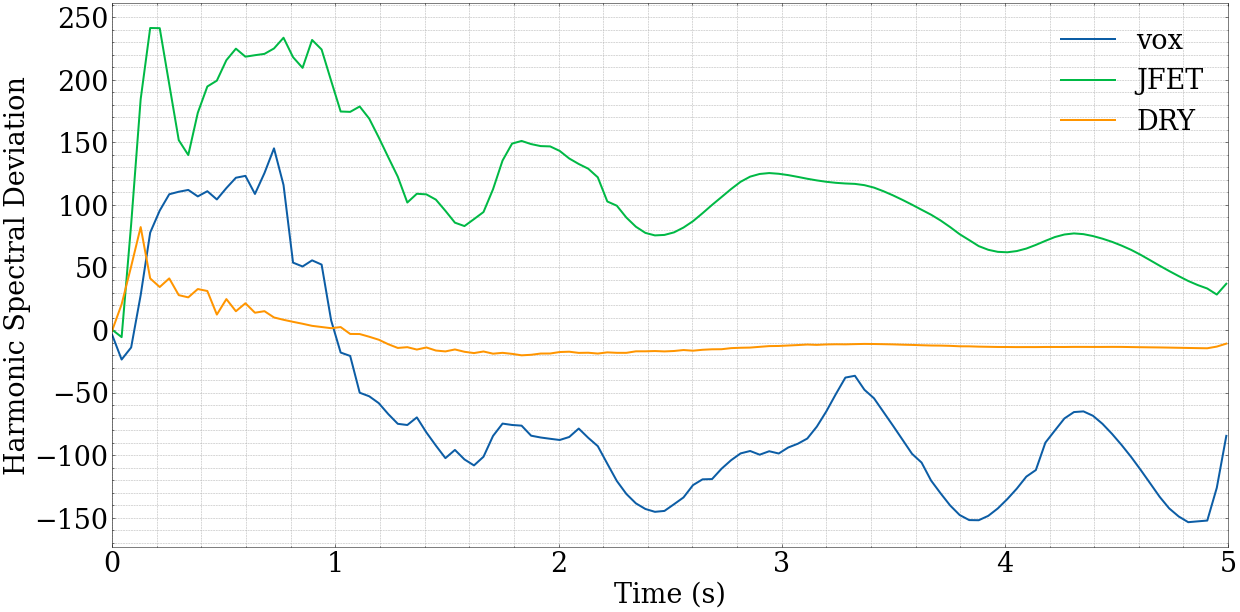

In [538]:
plot_SpectralDeviation(HSD_Vox_Hi_Gain_E2_String_Hi,HSD_JFET_Hi_Gain_E2_String_Hi,HSD_Dry_E2_String_Hi)

In [572]:
OER_error_diff(HSD_Vox_Hi_Gain_E2_String_Hi, HSD_Dry_D_Chord_Hi)

[3506.27, -9472.49, -12708.16, -10112.01, -11493.38, -8123.65]

In [573]:
OER_error_diff(HSD_JFET_Hi_Gain_E2_String_Hi, HSD_Dry_D_Chord_Hi)

[14152.47, 10167.6, 9141.65, 8715.85, 5280.08, 9571.29]

#### Med Gain

In [539]:
HSD_Dry_E2_String_Hi = SpectralDeviation(Dry_E2_String_Hi, 82)

In [540]:
HSD_Vox_Med_Gain_E2_String_Hi = SpectralDeviation(Vox_Med_Gain_E2_String_Hi, 82)

In [541]:
HSD_JFET_Med_Gain_E2_String_Hi = SpectralDeviation(JFET_Med_Gain_E2_String_Hi, 82)

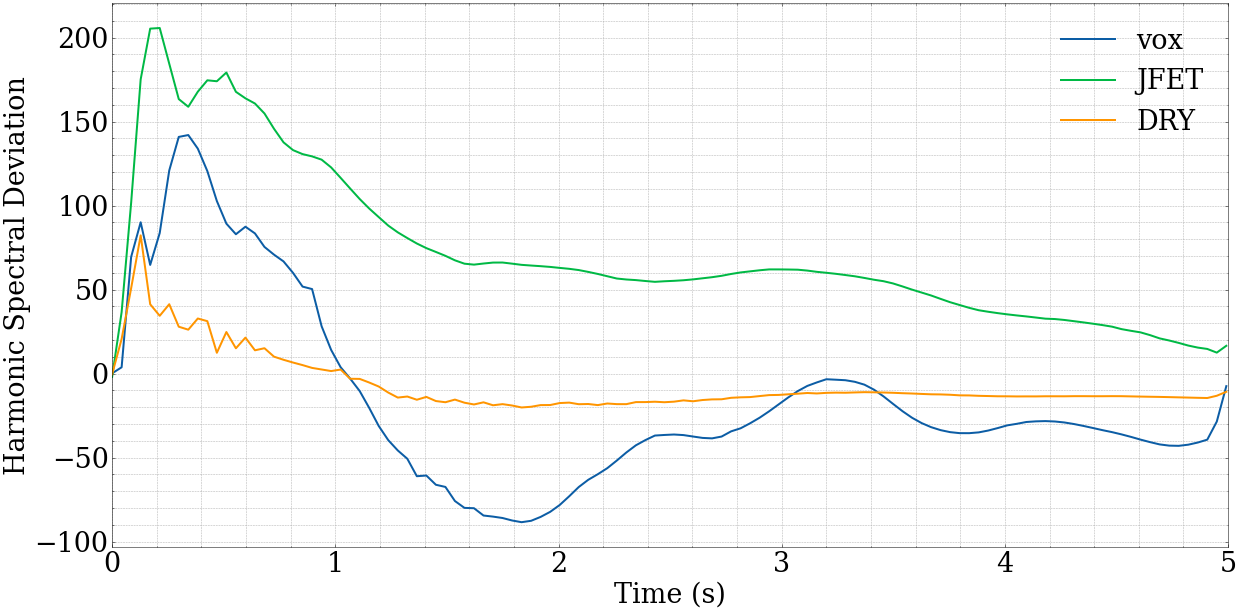

In [542]:
plot_SpectralDeviation(HSD_Vox_Med_Gain_E2_String_Hi,HSD_JFET_Med_Gain_E2_String_Hi,HSD_Dry_E2_String_Hi)

#### Low Gain

In [543]:
HSD_Dry_E2_String_Hi = SpectralDeviation(Dry_E2_String_Hi, 82)

In [544]:
HSD_Vox_Low_Gain_E2_String_Hi = SpectralDeviation(Vox_Low_Gain_E2_String_Hi, 82)

In [545]:
HSD_JFET_Low_Gain_E2_String_Hi = SpectralDeviation(JFET_Low_Gain_E2_String_Hi, 82)

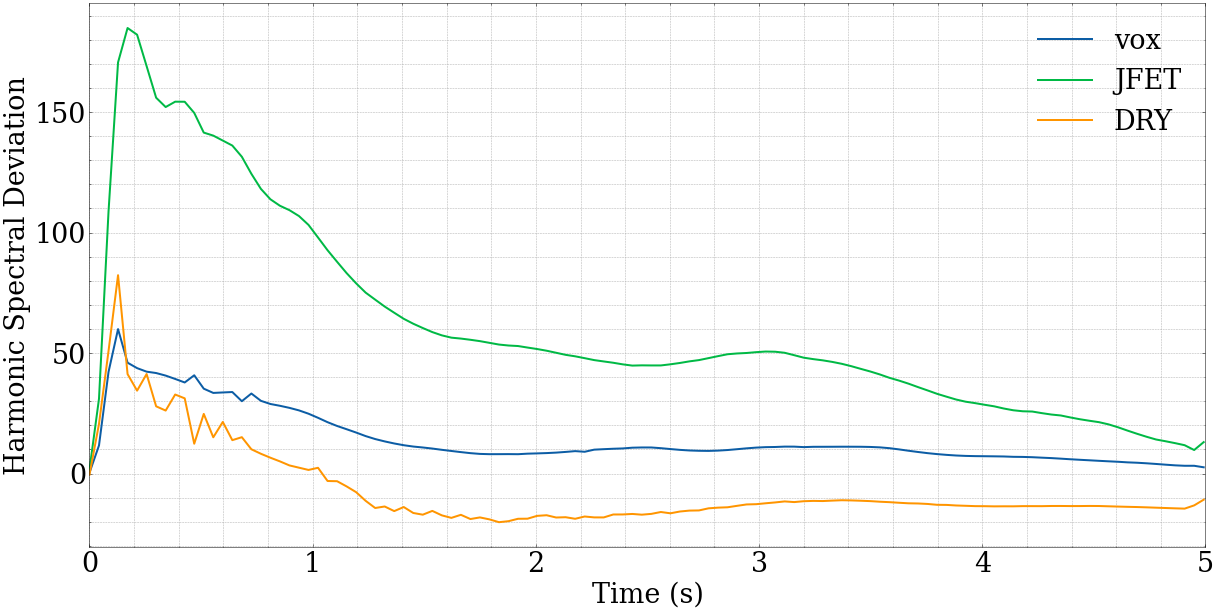

In [546]:
plot_SpectralDeviation(HSD_Vox_Low_Gain_E2_String_Hi,HSD_JFET_Low_Gain_E2_String_Hi,HSD_Dry_E2_String_Hi)

### D3 String

### E4 String

# fiddle 

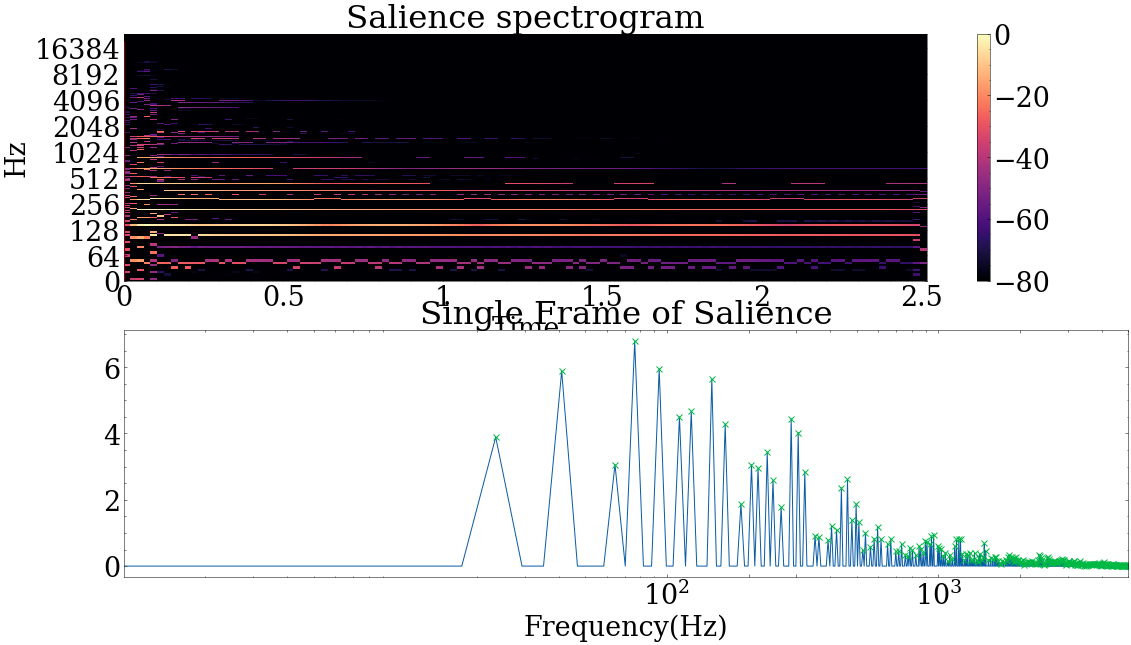

In [435]:
Salience_peaks_plot(Dry_D_Chord_Hi, 0)

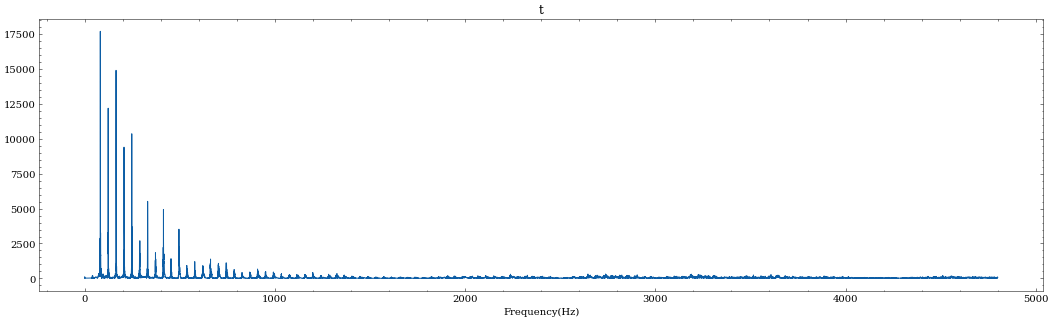

In [255]:
plot_magnitude_spectrum(Vox_Hi_Gain_E_Chord_Hi,title="t",sr=sr, f_ratio=0.1)

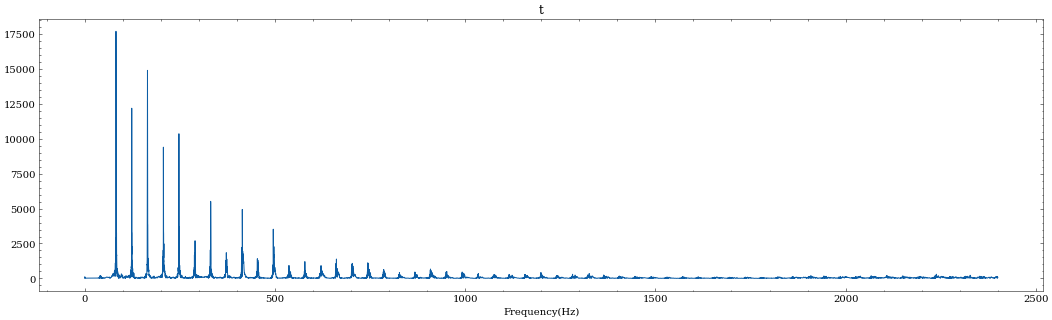

In [256]:
plot_magnitude_spectrum(Vox_Hi_Gain_E_Chord_Hi,title="t",sr=sr, f_ratio=0.05)

In [452]:
peaks = Salience_peaks(Dry_D_Chord_Hi, 0)

In [454]:
harms,_,_,fund=get_harmonics2(peaks, 147)

In [264]:
freqs = librosa.core.fft_frequencies(sr, n_fft=FRAME_SIZE)

In [195]:
onset = librosa.onset.onset_detect(Vox_Med_Gain_E_Chord_Hi)

In [480]:
sign = (librosa.stft(Dry_D_Chord_Hi, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))

In [482]:

spec_dev_frame=0
Spec_Dev = []
#for i in range( len(sign.T)):
peaks = Salience_peaks(Dry_D_Chord_Hi, 10)
harms, _, _, fund = get_harmonics2(peaks, 147)
for h in range(len(harms)-1):
    if h == 0:
        previous_harm = np.abs(sign[peaks[fund[0]]][10])
    else:
        previous_harm = np.abs(sign[harms[h-1]][10])
    
    current_harm = np.abs(sign[harms[h]][10])
    next_harm = np.abs(sign[harms[h+1]][10])
    
    Spectral_env = (previous_harm + current_harm + next_harm)/3

    spec_dev_frame += (current_harm - Spectral_env)

Spec_Dev.append(spec_dev_frame)  

